# Прогнозирование рыночной стоимости объектов недвижимости
---
<b>Цель:</b> Проанализировать данные, найдя зависимости. Найти признаки, влияющие на целевую переменную сильнее всего. Найти модель, которая будет показывать наилучший результат прогнозирования. Определиться с оптимальной для данной задачи метрикой.

<b>Описание:</b> В распоряжении архив объявлений о продаже квартир за несколько лет. По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

In [1]:
# исследовательский анализ
import numpy as np
import pandas as pd

# подключение к PostgreSQL
import psycopg2
from sqlalchemy import create_engine

# обработка данных
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

# подготовка обучающей выборки
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# модели
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans

# нейронные сети
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint

# оптимизация моделей
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

# визуализация
%matplotlib inline
%config InlineBckend.figure_format = 'retina'
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.figsize'] = (16,7)
sns.set_theme()

## 1. Загрузка данных
---
Заказчик сообщил, что данные хранятся на сервере компании. Необходимо подключиться к базе данных и получить нужные таблицы. Работа будет вестись с базой данных «ProjectsDatabase», внутри которой находится таблица «apartments_forecasting».

In [2]:
# создаём ключи доступа
data_base = {
    'user': 'postgres',
    'pwd': 'D300IYi0DV',
    'host': 'localhost',
    'port': 5432,
    'db': 'ProjectsDatabase'}

# создаём путь подключения
connection = 'postgresql://{}:{}@{}:{}/{}'.format(
    data_base['user'], data_base['pwd'], data_base['host'], data_base['port'], data_base['db'])

# подключаемся к базе данных
engine = create_engine(connection)

Подключение к базе «ProjectsDatabase» успешно создано. Теперь необходимо ознакомиться с хранящейся в ней таблицей «apartments_forecasting» и осмыслить структуру проекта.

In [3]:
# выбираем из базы данных таблицу «apartments_forecasting»
query = '''SELECT * FROM apartments_forecasting'''

# формируем таблицу
data = pd.read_sql_query(query, con=engine, index_col='id')

data.head(5)

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,airports_nearest,citycenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
id,,,,,,,,,,,,,,,,,,,,
0,20,11292982.0,108.0,3,2.70,16.0,51.0,8,None,False,False,25.0,NaN,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,4104986.0,40.4,1,NaN,11.0,18.6,1,None,False,False,11.0,2.0,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5975430.0,56.0,2,NaN,5.0,34.3,4,None,False,False,8.3,0.0,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,18438370.0,159.0,3,NaN,14.0,NaN,9,None,False,False,NaN,0.0,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10273356.0,100.0,2,3.03,14.0,32.0,13,None,False,False,41.0,NaN,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


В таблице представлено 20 признаков и 23699 строк. Благодаря большому количеству признаков можно создавать различные комбинации зависимостей. Выборка в 23699 наблюдений относительно небольшая, но, к сожалению, заказчик не смог предоставить больше данных, а значит, признаки, используемые для обучения моделей, необходимы быть информативны.

Проведём небольшие исследования таблицы «apartments_forecasting», чтобы понять спектр работы, который предстоит провести.

## 2. Разведочный анализ данных (EDA)
---
Проанализируем данные и попробуем выявить закономерности, влияющие на целевой признак, а также аномалии, которые помешают корректной интерпретации результата.

In [4]:
# функция построения графика распределения
def get_distribution_plot(data, column, limit=0, bins=20, boxplot=False):
    
    if boxplot == True: # график с боксплотом
        
        # задаём две оси графика
        figure, axis = plt.subplots(1, 2)
    
        # строим первый график
        axis[0].hist(data[column], lw=2.5, color="#748fa5", bins=bins)
        axis[0].axvline(np.mean(data[column]), color='#ffa600', label='Среднее', linewidth=2.5)
        axis[0].axvline(np.median(data[column]), color='#f95d6a', label='Медиана', linewidth=2.5)
        axis[0].legend(loc='upper right', frameon=False)
    
        # подписываем оси
        axis[0].set_title('Распределение')
        axis[0].set_xlabel('Значения')
        axis[0].set_ylabel('Плотность')
        
        if limit != 0:
            axis[0].set_xlim(0, limit)
    
        # строим второй график
        axis[1].boxplot(
            data[column], widths=0.5, patch_artist=True, showfliers=True, sym='.',
            medianprops={"color": "#f95d6a", "linewidth": 2.5},
            boxprops={"facecolor": "white", "edgecolor": "#748fa5", "linewidth": 2.5},
            whiskerprops={"color": "#748fa5", "linewidth": 2.5},
            capprops={"color": "#748fa5", "linewidth": 2.5},
            flierprops={'markeredgecolor': "#748fa5"})
    
        # подписываем оси
        axis[1].set_title('Выбросы')
        axis[1].set_xlabel('Значения')
        axis[1].set_ylabel('Плотность')
        axis[1].set_xticks([1], [f'Наблюдаемый признак: {column}'])
    
    else: # график с без боксплота
        # строим график
        plt.hist(data[column], lw=2.5, color="#748fa5", bins=bins)
        plt.axvline(np.mean(data[column]), color='#ffa600', label='Среднее', linewidth=2.5)
        plt.axvline(np.median(data[column]), color='#f95d6a', label='Медиана', linewidth=2.5)
        plt.legend(loc='upper right', frameon=False)
    
        # подписываем оси
        plt.title('Распределение')
        plt.xlabel('Значения')
        plt.ylabel('Плотность')
        
        if limit != 0:
            plt.xlim(0, limit)
    
    plt.show()

### 2.1. Анализ вещественных величин
---
Найдём корреляцию между целевой переменной и признаками, чтобы понять, существует ли на данном этапе линейная связь, либо она выражена более сложными функциями.

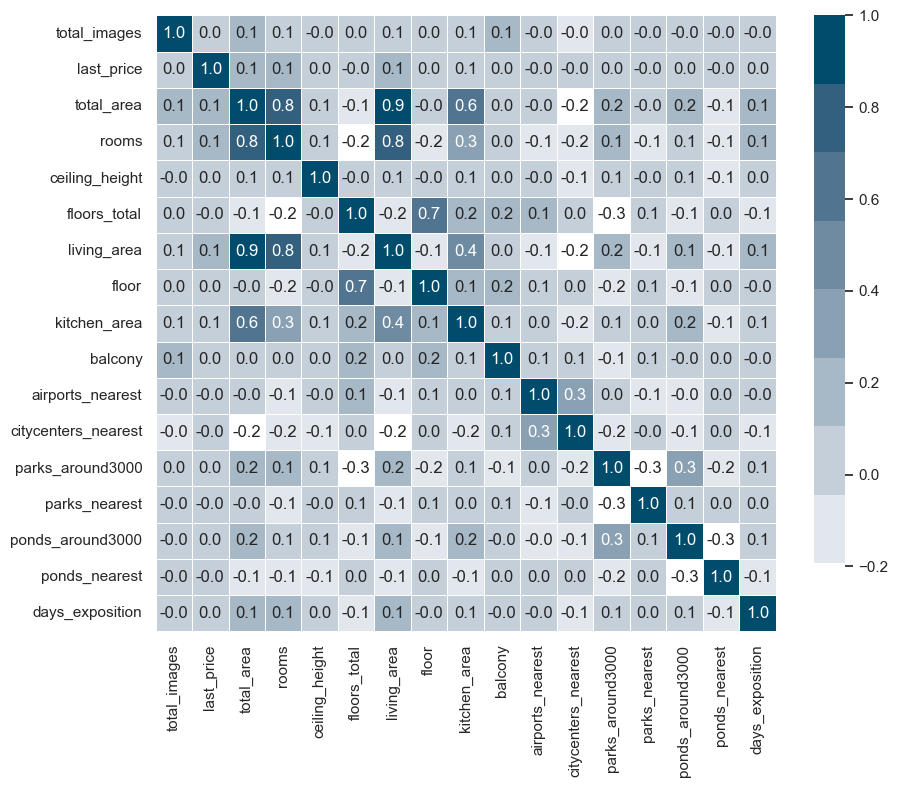

In [5]:
# выбираем цвета для графика
cmap = ListedColormap(['#ffffff', '#e1e7ec', '#c4cfd9', '#a7b8c6', '#8aa1b4', '#6e8ba1', '#517590', '#32607e', '#004c6d'])

# строим график вида хитмэп
plt.figure(figsize=(10, 8))
sns.heatmap(
    data.select_dtypes(include='number').corr(), annot=True, fmt=".1f", linewidths=.5,
    cmap=cmap)
plt.show()

Проанализировав данные, можно сделать вывод, что явной линейной связи между целевой переменной «last_price» и признаками нет, либо она незначительна. Однако это не исключает возможности существования более сложных взаимосвязей, таких как полиномиальная или степенная.

### 2.1.1. Признак ROOMS
---
Изучим, как цена зависит от количества комнат, чтобы понять закономерность.

In [6]:
query = '''
SELECT rooms,
       AVG(last_price) AS mean_price,
       PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY total_area) AS median_area
FROM apartments_forecasting
GROUP BY rooms
ORDER BY mean_price
'''

pd.read_sql_query(query, con=engine)

,rooms,mean_price,median_area
0,15,4.252519e+06,590.00
1,12,5.449556e+06,900.00
2,16,5.756300e+06,270.00
3,0,5.769507e+06,26.05
4,1,6.100482e+06,36.56
5,2,6.419216e+06,53.00
6,3,6.672450e+06,73.00
7,10,6.892120e+06,272.60
8,4,7.149669e+06,99.30
9,11,7.460744e+06,188.90


Разберёмся, что не так с квартирами, в объявлении которых указано 0 комнат.

In [7]:
query = '''
SELECT rooms,
       COUNT(*) AS total,
       COUNT(CASE WHEN studio THEN 1 END) AS studio,
       PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY last_price) AS median_price,
       PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY total_area) AS median_total_area,
       PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY living_area) AS median_living_area,
       PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY kitchen_area) AS median_kitchen_area
FROM apartments_forecasting
WHERE rooms = 0
   OR rooms = 1
GROUP BY rooms
'''

pd.read_sql_query(query, con=engine)

,rooms,total,studio,median_price,median_total_area,median_living_area,median_kitchen_area
0,0,197,138,4862136.0,26.05,18.0,NaN
1,1,8047,11,5048969.0,36.56,17.6,9.04


Как выяснилось, квартиры с обозначением 0 комнат на самом деле являются студиями. Это можно понять по соотношению количества наблюдений к числу отметок о том, что квартира является студией, а также по отсутствию информации о площади кухни, поскольку она не является отдельной комнатой. Это означает, что все пропуски в признаке «studio», где количество комнат равно 0, необходимо заполнить значениями 1.

Далее поймём, как поступить с квартирами, в которых больше 5 комнат, так как они искажают статистику. Например, квартира с 11 комнатами стоит гораздо дешевле, чем квартира с 6 комнатами. Важно понять, почему так происходит.

In [8]:
query = '''
SELECT rooms,
       COUNT(*) AS total,
       PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY last_price) AS median_price,
       PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY total_area) AS median_total_area,
       PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY living_area) AS median_living_area,
       PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY kitchen_area) AS median_kitchen_area
FROM apartments_forecasting
WHERE rooms > 5
GROUP BY rooms
ORDER BY rooms
'''

pd.read_sql_query(query, con=engine)

,rooms,total,median_price,median_total_area,median_living_area,median_kitchen_area
0,6,105,6258825.0,184.30,123.90,19.50
1,7,59,6032777.0,214.00,145.00,20.00
2,8,12,6491291.0,235.70,161.00,25.00
3,9,8,6247078.5,300.95,179.20,14.30
4,10,3,8193154.0,272.60,161.40,19.80
5,11,2,7460744.0,188.90,133.90,12.60
6,12,1,5449556.0,900.00,409.70,112.00
7,14,2,20405307.5,304.20,195.15,21.25
8,15,1,4252519.0,590.00,409.00,100.00
9,16,1,5756300.0,270.00,180.00,13.00


Предположительно, проблема была в том, что объявлений о продаже квартир с более чем 5 комнатами было мало. Люди не знали, какую сумму запрашивать. Если с 6 и 7 комнатными квартирами ещё можно было найти похожие варианты, то с квартирами, в которых больше 7 комнат, уже возникали трудности. Из-за этого цены сильно различаются и не отражают реальную стоимость жилья. Оптимальным решением будет удаление всех наблюдений, в которых указано более 7 квартир. Это позволит избежать увеличения дисперсии (разброса данных).

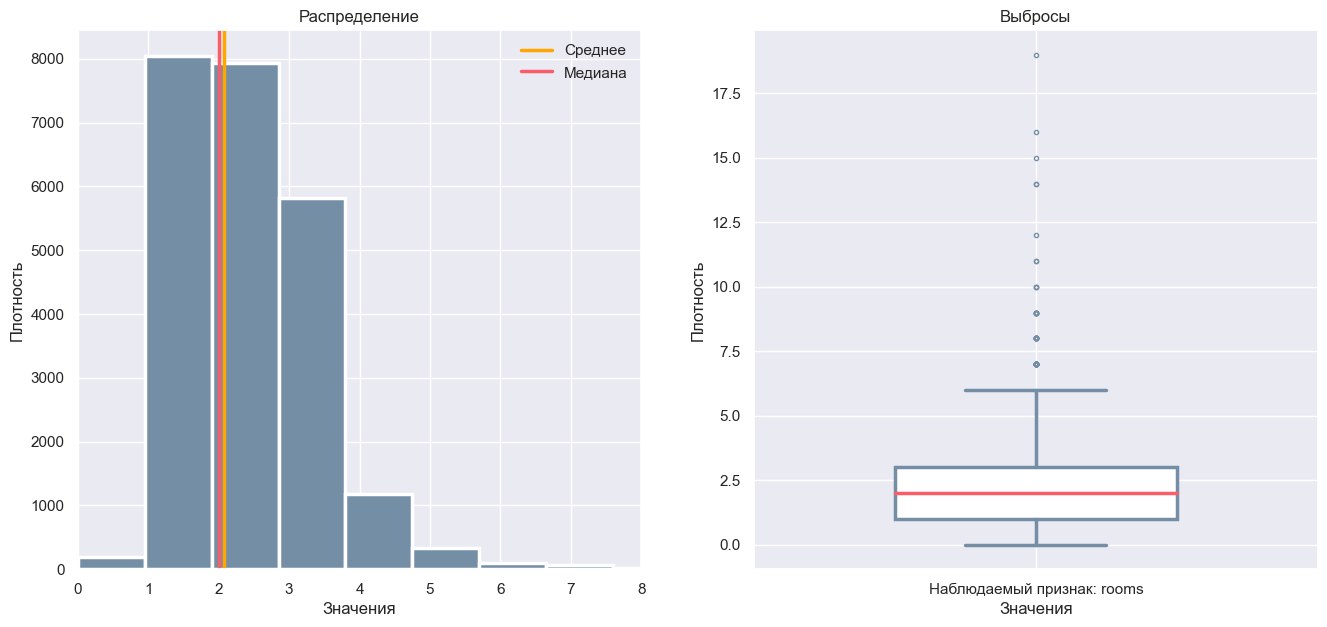

In [9]:
get_distribution_plot(data, 'rooms', limit=8, bins=20, boxplot=True)

Изучим распределение признака «rooms». Мы предположили, что квартиры, где указано «0» комнат, это студии, поэтому временно исключим их из выборки. Оказалось, что больше всего квартир с 1 или 2 комнатами, а количество 3 комнатных квартир почти в полтора раза меньше. Само же распределение скошено вправо, а также имеет незначительные выбросы, выходящие за пределы 2.698 сигм.

### 2.1.2. Признак CEILING_HEIGHT
---
Изучим, как цена зависит от высоты потолков, чтобы понять закономерность.

In [10]:
query = '''
SELECT CASE
           WHEN (ceiling_height >= 0 and ceiling_height < 2.3) THEN '0-2.3'
           WHEN (ceiling_height >= 2.3 and ceiling_height < 2.5) THEN '2.3-2.5'
           WHEN (ceiling_height >= 2.5 and ceiling_height < 3.2) THEN '2.5-3.2'
           WHEN (ceiling_height >= 3.2 and ceiling_height < 5) THEN '3.2-5'
           WHEN (ceiling_height >= 5) THEN '5+'
       END AS ceiling_category,
       COUNT(*) AS total,
       PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY last_price) AS median_price
FROM apartments_forecasting
WHERE ceiling_height IS NOT NULL
GROUP BY ceiling_category
ORDER BY median_price
'''

pd.read_sql_query(query, con=engine)

,ceiling_category,total,median_price
0,5+,37,5291878.0
1,2.3-2.5,57,5330053.0
2,2.5-3.2,13337,5547729.0
3,0-2.3,16,5846199.5
4,3.2-5,1057,5955261.0


Согласно данным компании ЦИАН, высота потолков в хрущёвках обычно составляет от 2.3 до 2.5 метров. В среднестатистических застройках этот показатель может быть от 2.5 до 3.2 метров, а в элитном жилье от 3.5 до 5 метров. Все остальные значения не могут существовать, поскольку потолки ниже 2.3 метров всегда являлись недопустимыми. Потолки ниже 2.3 метров не допускаются, а потолки выше 5 метров можно встретить крайне редко, в основном в частных домах. Из выборки нужно удалить все несуществующие варианты. Кроме того, следует добавить новый признак, который будет основываться на кластеризации. Это позволит разделить объекты на классы в зависимости от высоты потолков и цены.

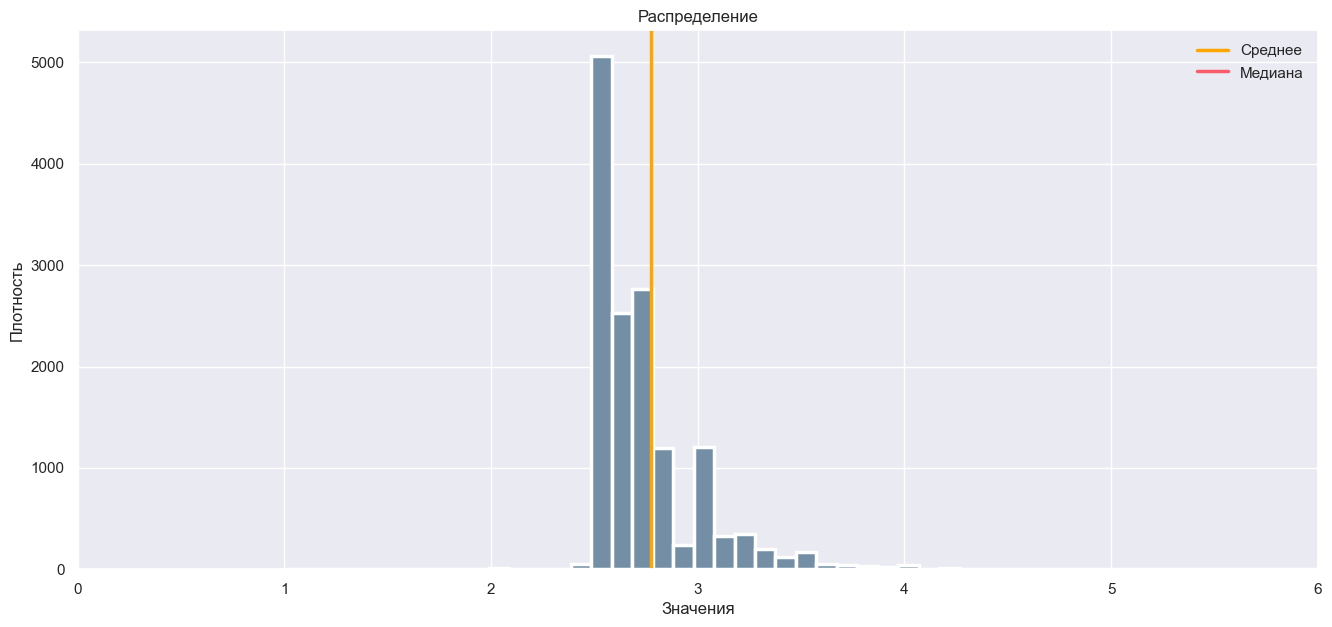

In [11]:
get_distribution_plot(data, 'ceiling_height', limit=6, bins=1000, boxplot=False)

Изучим распределение признака «ceiling_height». Сразу же бросается в глаза, что высота потолков в 2.5 метра является модой, а следом за ней идёт высота в 2.7 метров. Распределение скошено вправо, а также имеет незначительные выбросы.

### 2.1.3. Признак TOTAL_AREA
---
Изучим, как цена зависит от общей площади, чтобы понять закономерность.

In [12]:
query = '''
SELECT CASE
           WHEN total_area < 25 THEN '0-25'
           WHEN (total_area >= 25 and total_area < 50) THEN '25-50'
           WHEN (total_area >= 50 and total_area < 75) THEN '50-75'
           WHEN (total_area >= 75 and total_area < 100) THEN '75-100'
           WHEN (total_area >= 100 and total_area < 125) THEN '100-125'
           WHEN (total_area >= 125 and total_area < 150) THEN '125-150'
           WHEN (total_area >= 150) THEN '150+'
       END AS area_category,
       COUNT(*) AS total,
       PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY last_price) AS median_price
FROM apartments_forecasting
GROUP BY area_category
ORDER BY median_price
'''

pd.read_sql_query(query, con=engine)

,area_category,total,median_price
0,0-25,190,4713000.5
1,25-50,10745,5073759.0
2,50-75,8021,5864884.0
3,75-100,2835,6070791.0
4,100-125,945,6171489.0
5,125-150,381,6248821.0
6,150+,582,6272795.5


Можно заметить, что общая площадь квартир хорошо коррелирует с их ценой, поэтому этот признак должен быть значимым. Важно отметить, что иногда встречаются квартиры с общей площадью более 500 квадратных метров. Однако если в таких квартирах меньше 7 комнат, то их следует оставить в выборке, поскольку запрашиваемая за них цена является логичной и обоснованной. Чтобы повысить правдоподобность результатов, можно разделить общую площадь квартир с помощью кластеризации и создать на основе этого новый признак. 

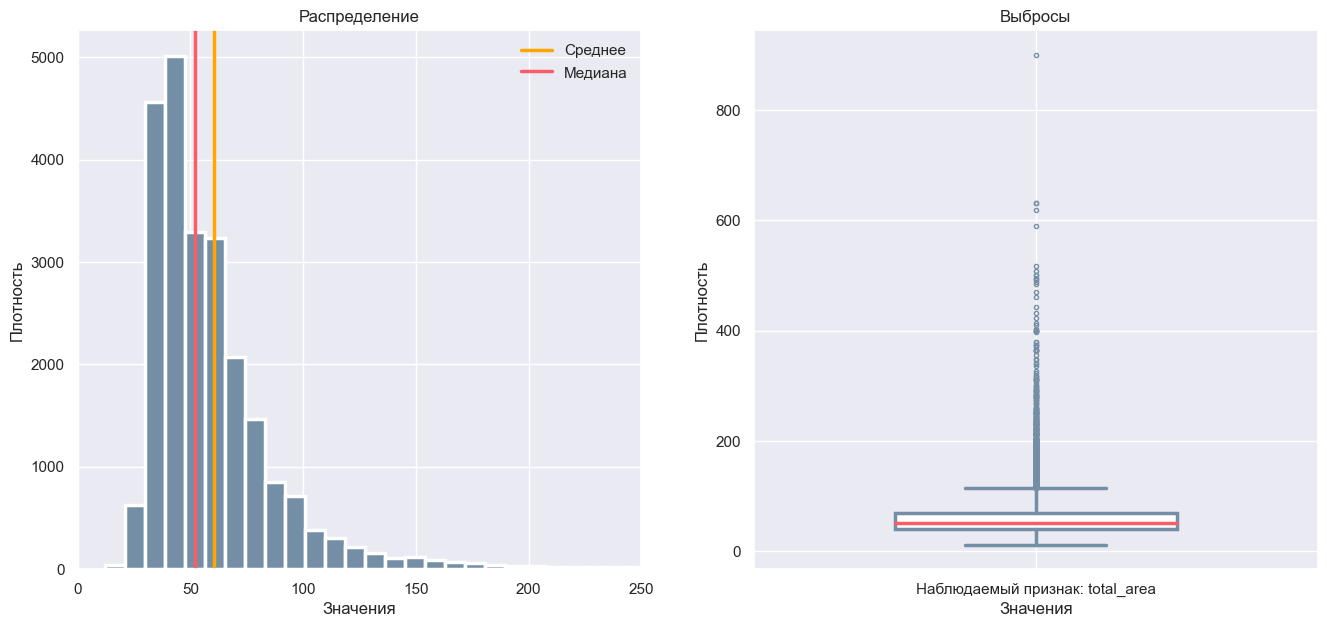

In [13]:
get_distribution_plot(data, 'total_area', limit=250, bins=100, boxplot=True)

Изучим распределение признака «total_area». Модой является площадь около 40 квадратных метров, а за ней следует площадь около 30 квадратных метров. Среднее значение смещено вправо от медианы на 10 квадратных метров, что указывает на наличие выбросов в данных. Это подтверждается и боксплотом, где выбросы обозначены точками. Распределение, как и в остальных случаях, скошено вправо.

### 2.1.4. Признаки FLOOR & FLOORS_TOTAL
---
Изучим, как цена зависит от этажа, а также общего количества этажей, чтобы понять закономерность.

In [14]:
query = '''
SELECT CASE
           WHEN floors_total = 1 THEN '1'
           WHEN floors_total = 2 THEN '2'
       END AS floors_category,
       COUNT(*) AS total,
       PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY last_price) AS median_price
FROM apartments_forecasting
GROUP BY floors_category
ORDER BY total
LIMIT 2
'''

pd.read_sql_query(query, con=engine)

,floors_category,total,median_price
0,1,25,4721752.0
1,2,383,5757470.0


Интересно заметить, что в данных присутствуют наблюдения с квартирами, в которых всего 1–2 этажа. Возможно, это дома старой застройки либо частные дома. Данную информацию стоит уточнить у заказчика.

In [15]:
query = '''
SELECT CASE
           WHEN (floor = 1 AND floors_total > 2) THEN 'first'
           WHEN (floor = floors_total) THEN 'last'
           ELSE 'others'
       END AS floor_category,
       COUNT(*) AS total,
       PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY last_price) AS median_price
FROM apartments_forecasting
GROUP BY floor_category
ORDER BY median_price DESC
'''

pd.read_sql_query(query, con=engine)

,floor_category,total,median_price
0,others,17641,5572976.0
1,first,2697,5550763.0
2,last,3361,5513658.0


Необходимо добавить новый признак с отметкой для первого и последнего этажей, поскольку их влияние на цену более значительно. Если в доме всего один этаж, то его можно рассматривать как частный дом, так как его медианная стоимость выше, чем у двухэтажных жилых домов.

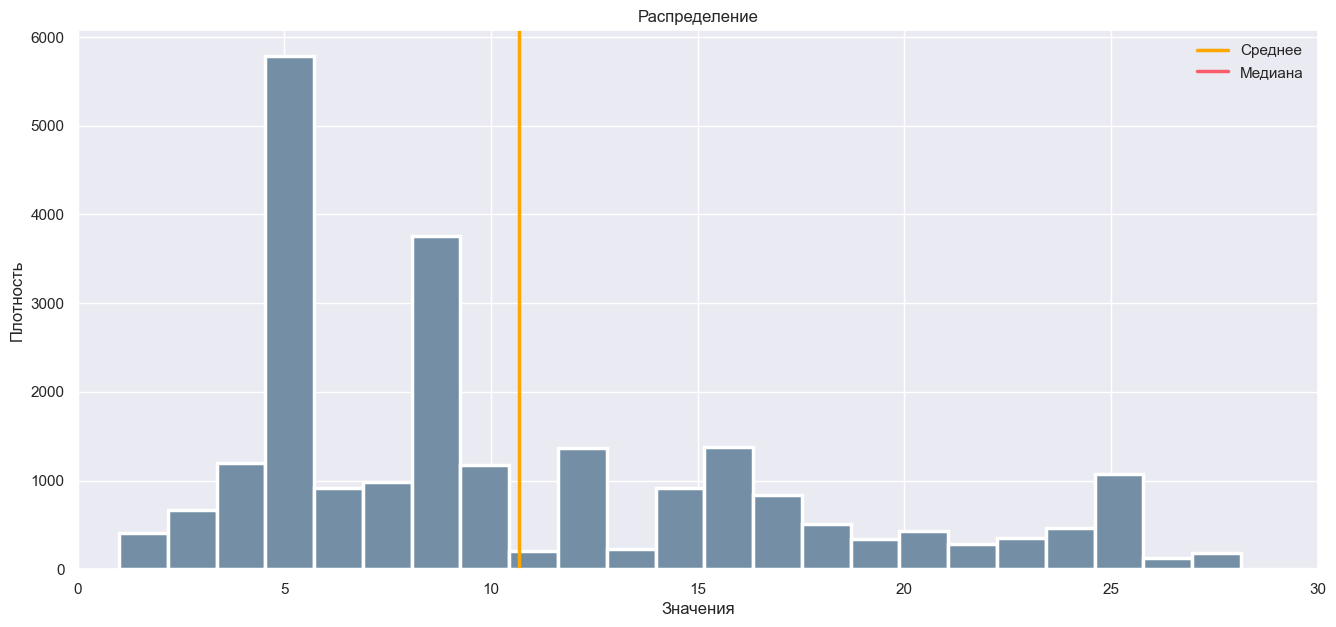

In [16]:
get_distribution_plot(data, 'floors_total', limit=30, bins=50, boxplot=False)

Изучим распределение признака «floors_total». Наиболее часто встречаются 5 этажные здания, за ними следуют 9 этажные. Это соответствует истине, поскольку застройщики предпочитают строить дома в 5 этажей, для которых по закону не требуется установка лифтов. Кроме того, 9 этажные здания также пользуются спросом, поскольку в них можно установить обычные лифты. Дома высотой в 12 и 16 этажей менее популярны среди застройщиков, поскольку для них требуются более мощные лифты. Распределение не имеет выраженного скоса вправо, но, если ориентироваться по выбивающимся значениям, то его возможно разглядеть.

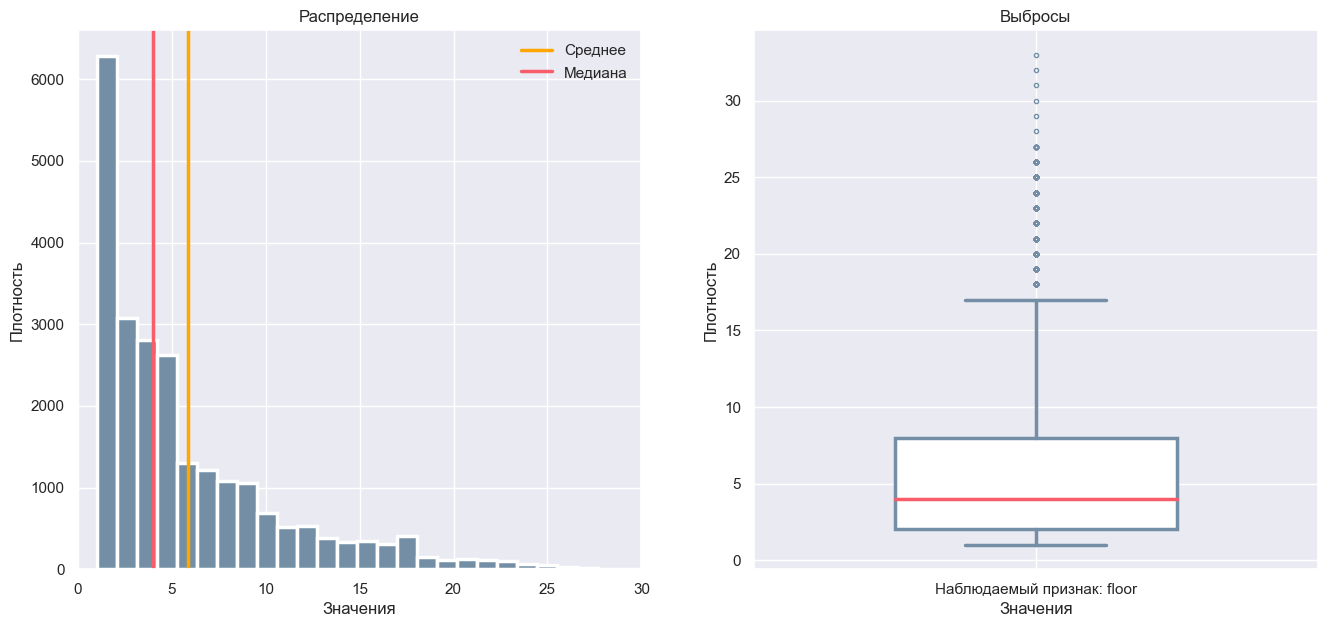

In [17]:
get_distribution_plot(data, 'floor', limit=30, bins=30, boxplot=True)

Изучим распределение признака «floor». Зачастую в объявлениях выставляются квартиры, расположенные на первом этаже. Отчётливо выслеживается тенденция на уменьшение числа предложений с повышением этажности. В данных присутствуют незначительные выбросы.

## 2.2. Анализ дискретных величин
---
Проанализируем категориальные переменные, чтобы сравнить их между собой, а также найти возможные зависимости.

In [18]:
# функция построения боксплота
def get_box_plot(data, column):
    
    # строим график
    plt.boxplot(
        data, widths=0.5, patch_artist=True, showfliers=False, sym='.',
        medianprops={"color": "#f95d6a", "linewidth": 2.5},
        boxprops={"facecolor": "white", "edgecolor": "#748fa5", "linewidth": 2.5},
        whiskerprops={"color": "#748fa5", "linewidth": 2.5},
        capprops={"color": "#748fa5", "linewidth": 2.5},
        flierprops={'markeredgecolor': "#748fa5"})
    
    # подписываем оси
    plt.xticks(range(1, len(column) + 1), column)
    plt.title(f'Сравнение значений')
    plt.xlabel('Значения')
    plt.ylabel('Распределение')
    
    plt.show()

### 2.2.1 Признак IS_APARTMENT
---
Изучим, как целевой признак зависит от категориального признака «is_apartment».

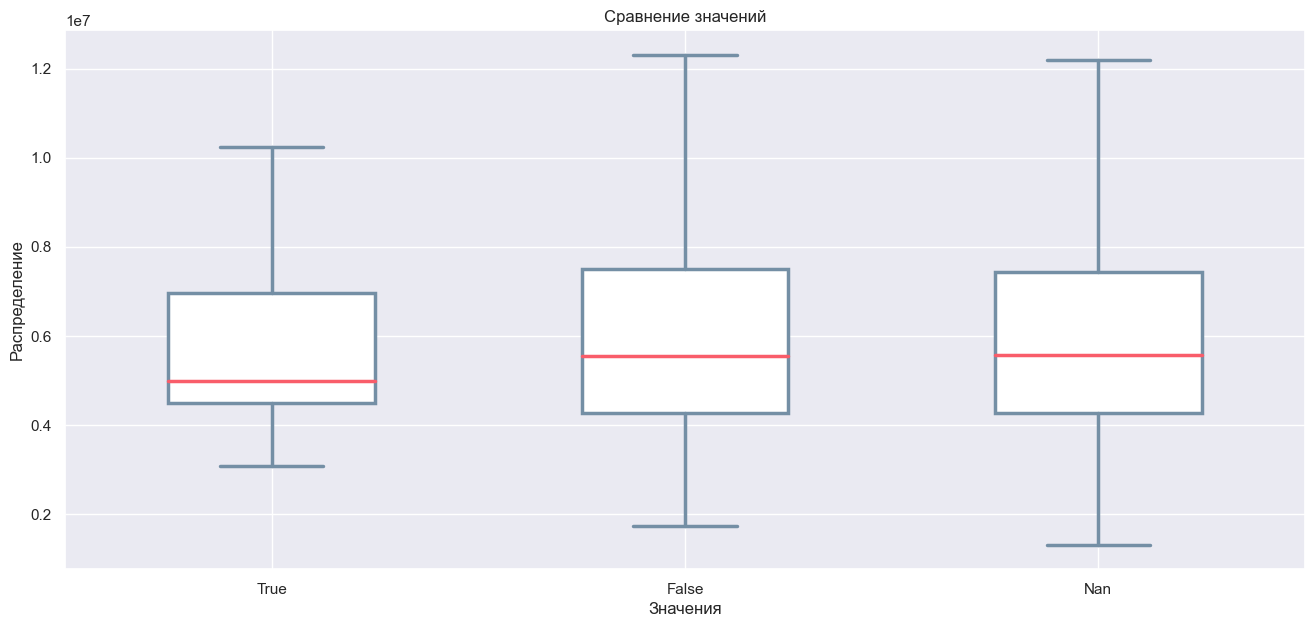

In [19]:
chart_1 = data[data['is_apartment'] == 'True']['last_price']
chart_2 = data[data['is_apartment'] == 'False']['last_price']
chart_3 = data[data['is_apartment'].isna() == True]['last_price']

get_box_plot([chart_1, chart_2, chart_3], ['True', 'False', 'Nan'])

In [20]:
data.groupby('is_apartment', as_index=True).agg(np.mean)

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,studio,open_plan,kitchen_area,balcony,airports_nearest,citycenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
is_apartment,,,,,,,,,,,,,,,,,,,
False,9.230092,6.411579e+06,61.123761,2.086606,2.873812,10.737248,35.026973,5.976147,0.005505,0.002569,10.750020,1.207322,28524.539705,14208.418726,0.614068,508.614224,0.795152,502.630019,218.556458
True,11.160000,6.078977e+06,83.325800,2.080000,6.313864,6.900000,47.979524,4.480000,0.000000,0.000000,17.727429,2.064516,33166.463415,14851.000000,0.953488,255.263158,1.232558,534.200000,258.736842


Проанализировав признак «is_apartment», можно заметить, что медиана значений True и False различается, но не сильно. При этом распределение значений False более широкое, чем у True. Следует обратить особое внимание на пропуски в данных Nan, поскольку они почти полностью соответствуют распределению признака False. Это означает, что можно заполнить пропуски значениями False, либо пометить их как выбросы, создав третий класс.

### 2.2.2 Признак STUDIO
---
Изучим, как целевой признак зависит от категориального признака «studio».

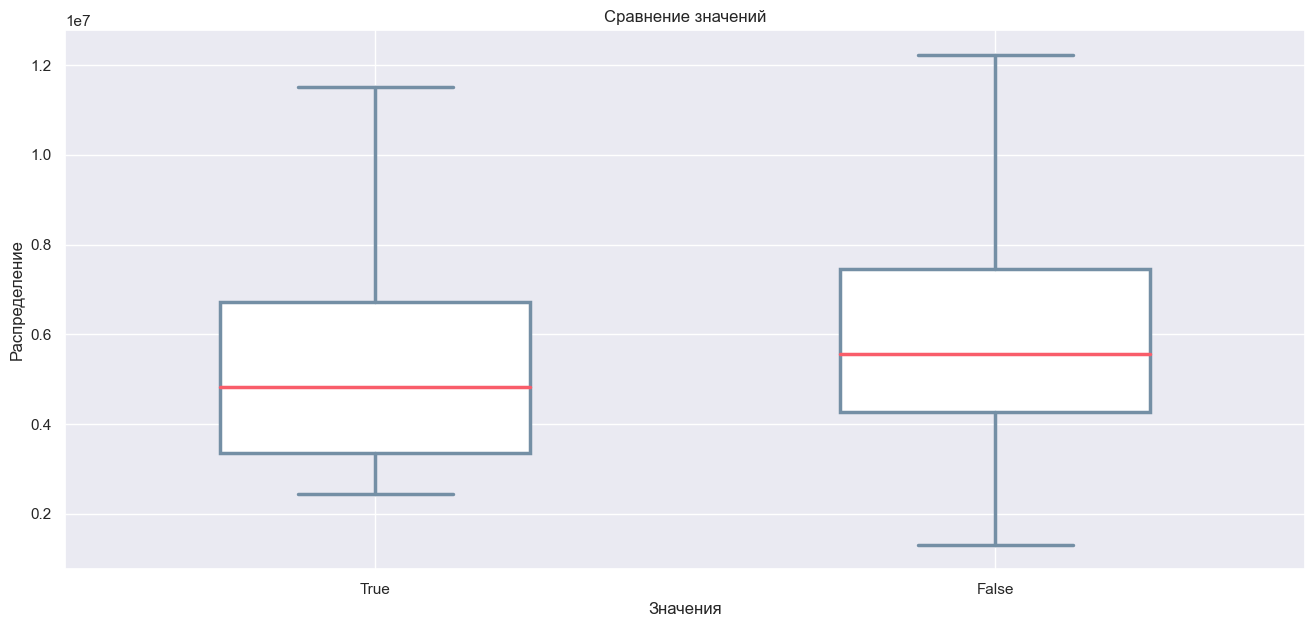

In [21]:
chart_1 = data[data['studio'] == True]['last_price']
chart_2 = data[data['studio'] == False]['last_price']

get_box_plot([chart_1, chart_2], ['True', 'False'])

Оценим признак «is_apartment». Если посмотреть на распределение значений, можно увидеть, что медиана для True и False отличается. Квартиры, не помеченные как «студия», в среднем стоят дороже, чем те, которые помечены как «студия».

### 2.2.3 Признак OPEN_PLAN
---
Изучим, как целевой признак зависит от категориального признака «open_plan».

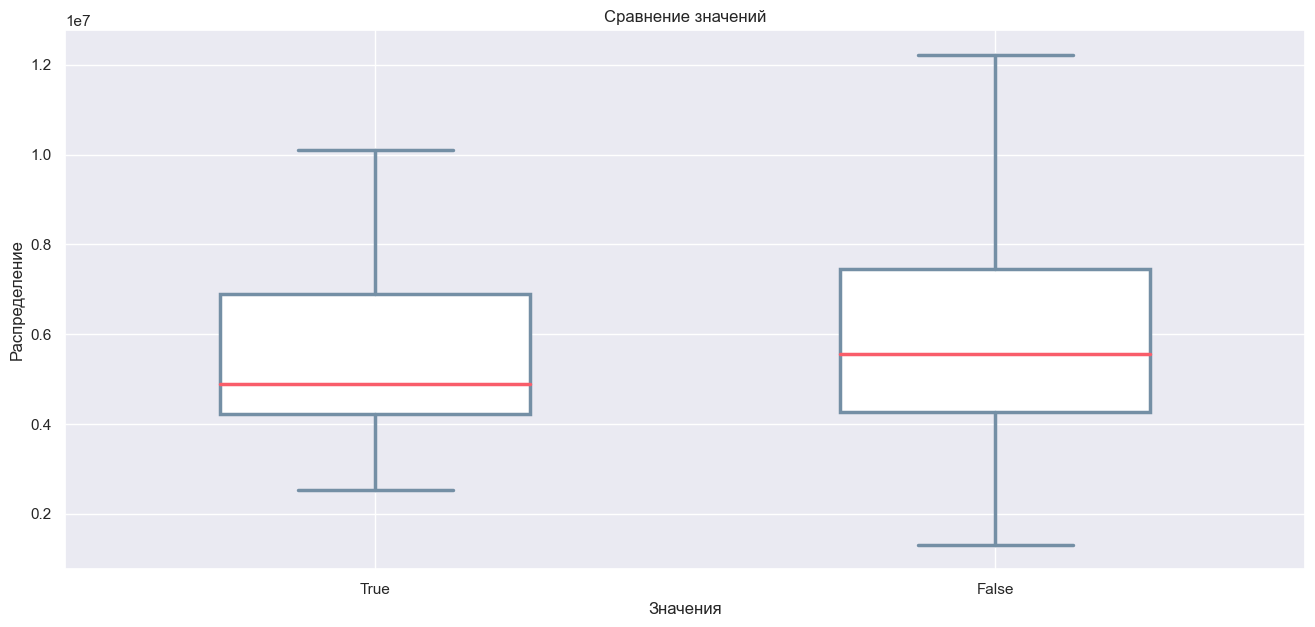

In [22]:
chart_1 = data[data['open_plan'] == True]['last_price']
chart_2 = data[data['open_plan'] == False]['last_price']

get_box_plot([chart_1, chart_2], ['True', 'False'])

Рассмотрим признак «open_plan». Как и в предыдущем случае, медианные значения отличаются, а средняя стоимость квартир без пометки «с открытым планом» выше.

## 3. Обработка данных (DP)
---
Предварительно обработаем признаки, чтобы исключить пропуски и дубликаты. Это поможет провести качественный анализ данных и улучшить метрики моделей машинного обучения.

In [23]:
# разделим признаки на числовые и категориальные
num_col_names = data.select_dtypes(include='number').columns.tolist()
cat_col_names = data.select_dtypes(include=['object', 'bool']).columns.tolist()

# удалим таргет из признаков, чтобы не допустить утечку
num_col_names.remove('last_price')

### 3.1. Работа с пропусками
---
Пропуски в данных могут возникать по разным причинам, и их обработка зависит от типа данных.

#### 3.1.1 Числовые пропуски
---
Существуют различные способы заполнения числовых пропусков в данных. Например, можно использовать среднее значение или моду. Также можно вычислить среднее или медиану по N ближайшим соседям. В этой задаче мы будем использовать алгоритм ядерного KNN для заполнения пропусков. В отличие от медианы или среднего, ядерный KNN позволяет найти не просто среднее или медиану, а среднее и медиану по K соседям и оценивать расстояние до них, задавая уровень значимости для каждого такого соседа. Рассмотрим подробнее работу алгоритма.

В самом начале необходимо выбрать функцию расстояния. Например, выбрать можно между евклидовой $\rho(x, y) = \sum_i \vert x_i - y_i \vert_2$, манхэттенской $\rho(x, y) = \sum_i \vert x_i - y_i \vert$, любой метрикой Минковского больше второй степени $\rho(x, y) = \left(\sum_i \vert x_i - y_i\vert^p\right)^{1/p}$, также можно вычислить и косинус $\rho(x,y) = 1 - \cos \theta = 1 - \frac{x \cdot y}{|x| |y|}$. Но мы остановимся на базовом евклидовом расстоянии, чтобы понимать, что алгоритм вычисляет ближайших соседей простым расстоянием. В итоге самые ближайшие соседи и будут выбраны для назначения пропущенного значения.

Алгоритм KNN легко обобщить на решение задачи регрессии, например, можно брать обычное среднее расстояние $a(u) = \frac1k \sum_{i=1}^k y_u^{(i)}$, либо его взвешенный вариант:

$$a(u) = \frac{\sum_{i=1}^k K\left(\frac{\rho(u, x_u^{(i)})}{h}\right) y_u^{(i)}}{\sum_{i=1}^k K\left(\frac{\rho(u, x_u^{(i)})}{h}\right)}$$

Но использовать данную формулу напрямую не получится, поскольку в ней определяется мера близости двух объектов, а если объекты совпадают, то выдаётся 1, а в другом случае 0. Поэтому необходимо заменить индикатор на более гладкую функцию. Например, на ранее рассмотренное евклидово расстояние, благодаря которому мы получаем формулу:

$$a(u) = \underset{y\in \mathbb{R}}{\operatorname{arg min}} \sum_{i=1}^k K\left(\frac{\rho(u, x_u^{(i)})}{h}\right)(y- y_u^{(i)})^2$$

В итоге мы получили ядерную функцию, которая вычисляет не близость до объектов, а использует сами расстояния как метрики. Кстати, с выбором самого ядра тоже можно поэкспериментировать, ведь существуют прямоугольные ядра $K(x) = \frac12 \mathbb{I} \left[ \vert x \vert \leqslant 1\right]$, треугольные $K(x) = \left(1 - \vert x \vert \right)\mathbb{I}\left[\vert x \vert \leqslant 1\right]$, гаусовское ядро $K(x) = \frac{1}{\sqrt{2\pi}}e^{-2x^2}$ и прочие. На практике чаще всего используют либо прямоугольное для простоты, либо гауссовское, в случае когда важна гладкость модели, например в задачах регрессии. Ширина окна, в свою очередь, сильно влияет как раз на качество модели. При слишком маленькой ширине модель сильно подстраивается под обучающую выборку и теряет свою обобщающую способность. При слишком большой ширине, напротив, модель становится слишком простой. Универсальной ширины окна не существует, поэтому для каждой задачи её приходится подбирать отдельно.

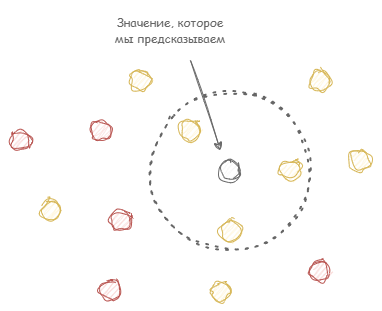

Ещё одним важным параметром является количество ближайших соседей, которых алгоритм рассматривает при принятии решения. Увеличение числа соседей может повысить точность прогнозирования, так как это позволяет алгоритму лучше учитывать контекст и разнообразие данных. Однако слишком большое количество соседей может привести к снижению точности результатов из-за влияния выбросов и шума. Кроме того, увеличение числа соседей делает результаты менее интерпретируемыми, поскольку становится сложнее объяснить, почему был выбран тот или иной сосед. Также это приводит к увеличению времени обучения модели и времени, необходимого для прогнозирования, поскольку алгоритм должен обработать больше данных. Это связано с тем, что необходимо вычислить расстояния до всех соседей и выбрать наиболее подходящие из них.

In [24]:
# создаём функцию KNNImputer для заполнения пропусков
imputer = KNNImputer(n_neighbors=5, weights='distance', metric='nan_euclidean')

# заполняем пропуски в числовых признаках при помощи KNN
features = pd.DataFrame(data=imputer.fit_transform(data[num_col_names]), columns=num_col_names)

# добавляем целевую переменную
features['last_price'] = data['last_price']

#### 3.1.2 Категориальные пропуски
---
В категориальных данных есть пропуски только в столбце «is_apartment», но их количество превышает 88%, из-за этого нельзя восстановить пропущенные значения с помощью методов машинного обучения. Необходимо использовать другой подход. Отметим пропуски как пропуски, чтобы модель сама определила, как они влияют на целевую перемнную.

In [25]:
# заполним новым значением
data.loc[data['is_apartment'].isna() == True, 'is_apartment'] = 'Gap'

# сохраним данные в признаки
features[cat_col_names] = data[cat_col_names]

### 3.2. Работа с дубликатами
---
Перед передачей данных в модель важно удалить повторяющиеся записи. Дубликаты могут негативно повлиять на результаты анализа и обучения модели, а также увеличить размер выборки, не добавляя новой информации, что может привести к переоценке важности некоторых признаков.

In [26]:
# удаляем дубликаты
features = features.drop_duplicates().reset_index(drop=True)

## 4. Генерация новых признаков (FE)
---
Ранее мы определили, какие признаки нужно добавить, а какие изменить или улучшить. Теперь мы готовы приступить к их созданию. Генерация новых признаков позволяет значительно улучшить качество моделей. Новые признаки добавляют дополнительную информацию о данных, делая их более разнообразными и информативными. 

1. Заполняем пропуски в столбце «studio» значениями True, где «rooms» равно 0.

In [27]:
features.loc[features['rooms'] == 0, 'studio'] = 'True'

2. Удалим все наблюдения, в которых более 7 комнат.

In [28]:
features = features.loc[features['rooms'] < 8]

3. Удалим все значения в столбце «ceiling_height», если они меньше 2.3 и больше 5.

In [29]:
features = features.loc[(features['ceiling_height'] >= 2.3) & (features['ceiling_height'] <= 5)]

4. Создадим новый признак на основе кластеризации, который будет разграничивать наблюдения по признаку «ceiling_height».

In [30]:
# функция построения графика обучения
def get_cluster_plot(data):
    
    error = []
    
    # перебираем различное число кластеров
    for cluster in range(1, 9):
        
        # создаём модель
        model = KMeans(n_clusters=cluster, n_init='auto', random_state=21)
        
        # обучаем модель
        model.fit(data)
        
        # считаем ошибку
        error.append(model.inertia_)
        
    # строим график
    plt.plot(range(1, 9), error)
    plt.title('Отношение ошибки к числу кластеров')
    plt.xlabel('Количество')
    plt.ylabel('Ошибка')

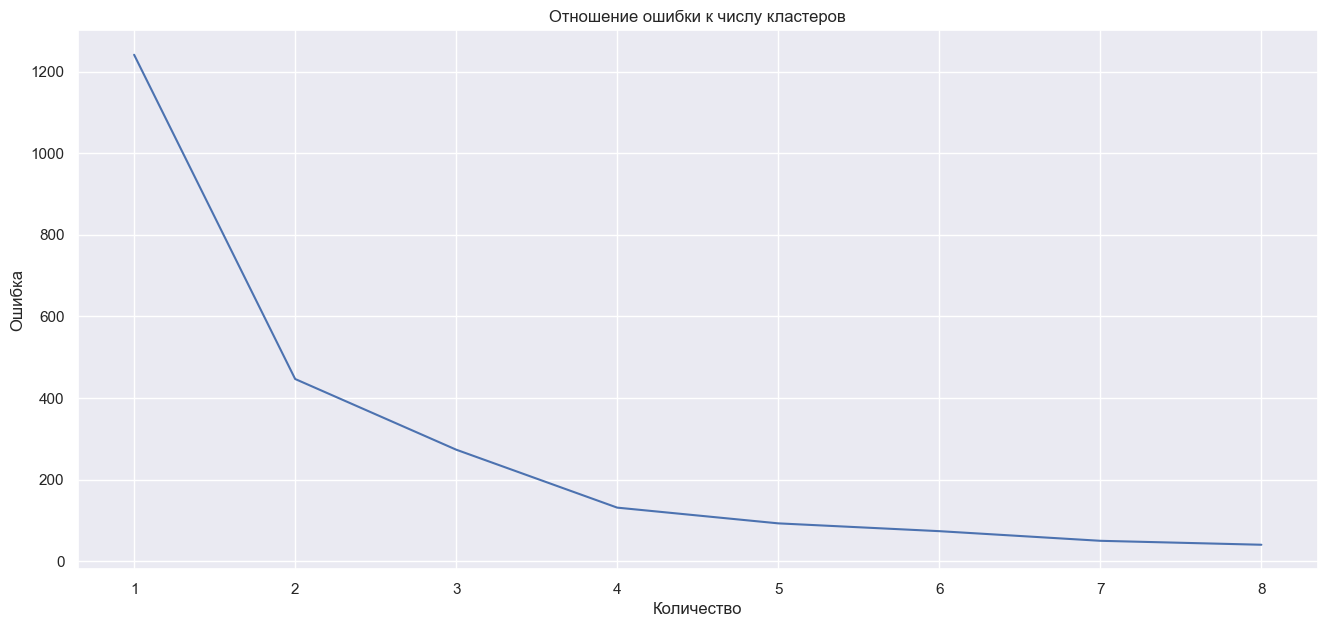

In [31]:
get_cluster_plot(features[['ceiling_height']])

Оптимальным количеством кластеров для признака «ceiling_height» будет 3, так как после значения 4 на графике ошибка начинает снижаться незначительно.

In [32]:
# создаём модель с тремя кластерами
model = KMeans(n_clusters=3, n_init='auto', random_state=21)

# обучаем модель и делаем предсказания
features['ceiling_height_clusters'] = model.fit_predict(features[['ceiling_height']])

5. Создадим новый признак на основе кластеризации, который будет разграничивать наблюдения по признаку «total_area».

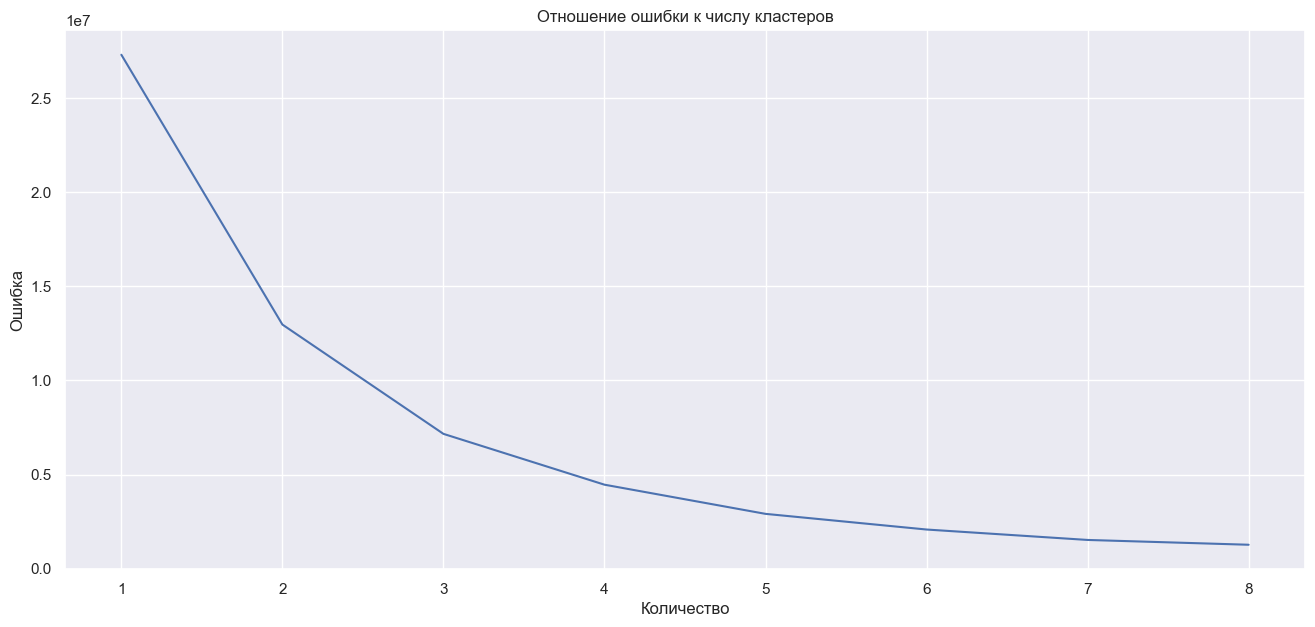

In [33]:
get_cluster_plot(features[['total_area']])

Оптимальным количеством кластеров для признака «ceiling_height», как и для признака «total_area», будет 3, так как после значения 4 на графике ошибка начинает снижаться незначительно. Если выбрать число кластеров больше 3, это может привести к переобучению используемых моделей или, наоборот, к потере информации при разделении оптимальных кластеров на более мелкие.

In [34]:
# создаём модель с тремя кластерами
model = KMeans(n_clusters=3, n_init='auto', random_state=21)

# обучаем модель и делаем предсказания
features['total_area_clusters'] = model.fit_predict(features[['total_area']])

6. Создадим новый признак с отметками о первом и последнем этажах в доме.

In [35]:
features.loc[(features['floor'] == 1) | (features['floor'] == features['floors_total']), 'furthest'] = 1
features['furthest'] = features['furthest'].fillna(0)

7. Создадим новый признак с отметкой о частном доме, если у него всего 1 этаж.

In [36]:
features.loc[features['floors_total'] == 1, 'house'] = 1
features['house'] = features['house'].fillna(0)

## 5. Обработка выбросов (EH)
---
Для машинного обучения крайне важно обнаруживать выбросы. Это позволяет улучшить качество данных, выявить аномалии и повысить стабильность модели. Давайте найдём аномалии для каждого числового признака, кроме целевого, и обозначим их цифрой «1». Решение о том, как поступить с выбросами, будет зависеть от их количества.

Чтобы обнаружить выбросы, мы могли бы использовать правило трёх сигм. Согласно этому правилу, в нормальном распределении около 99.3% всех значений находятся в пределах 2.698 стандартных отклонений от среднего значения. Остальные значения считаются выбросами.

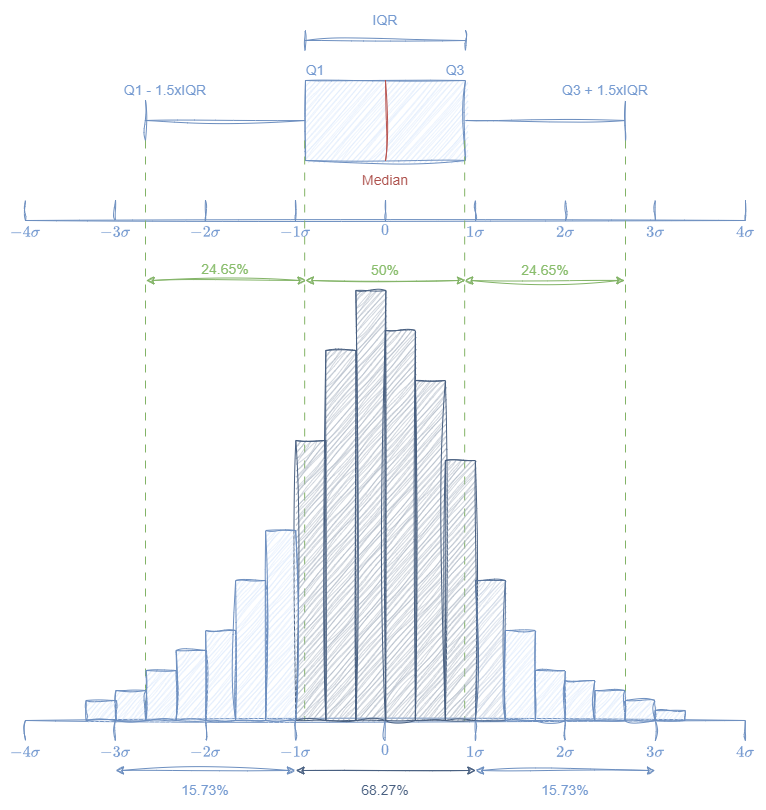

Однако этот метод применим только в случае нормального распределения или распределения, близкого к нормальному. Но, как мы знаем, наши признаки распределены далеко не нормально. Чтобы это проверить, помимо уже построенных графиков распределения, создадим также Q-Q Plot. Он позволит увидеть, насколько наши выборочные значения хорошо соответствуют предсказанным значениям, если бы наше распределение было бы нормальным. 

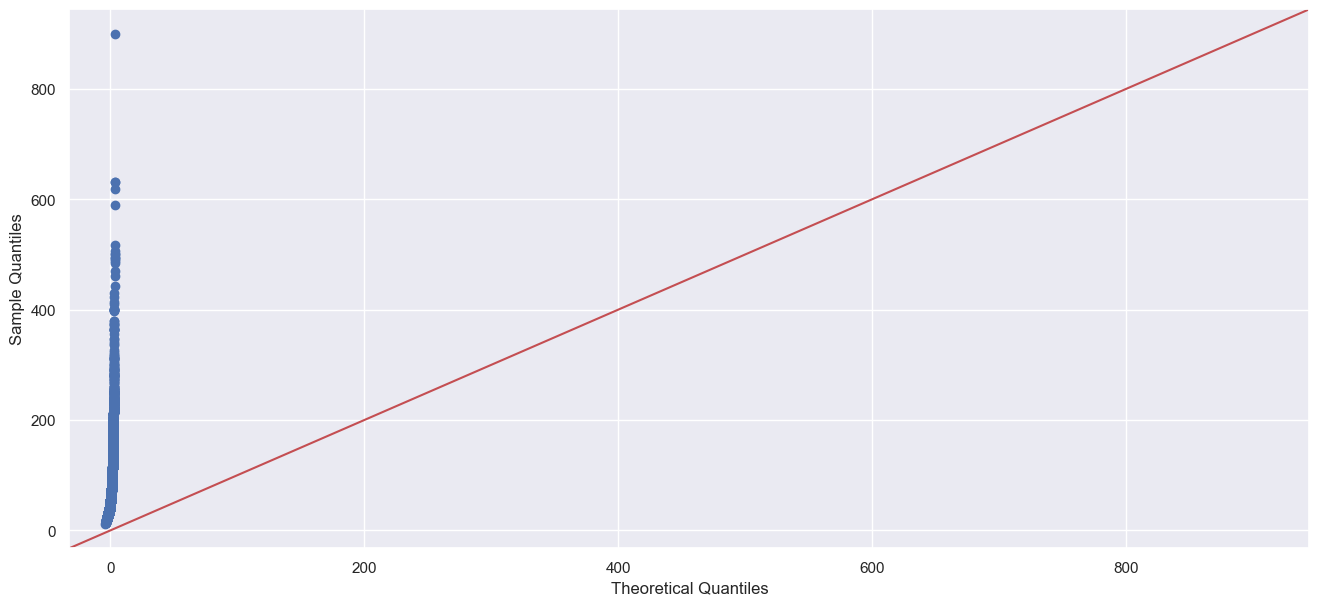

In [37]:
# строим квантиль-квантиль плот
sm.qqplot(data['total_area'], line='45');

На графике была произведена оценка всего одного признака, но все остальные показывают аналогичный вариант, подтверждая, что распределение далеко от нормального, а значит, использовать обработку выбросов при помощи классического правила трёх сигм нельзя. Поэтому оценим выбросы, используя не 1.5 межквартильного размаха, а 0.5 для левой границы и 2.0 для правой.

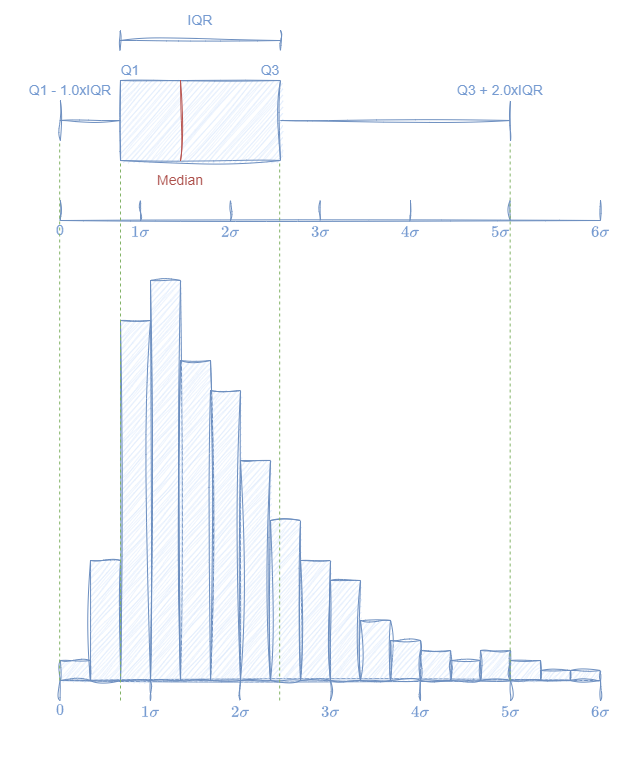

In [38]:
# функция поиска выбросов по квартилям
def get_quartiles_outliers(data, column, counts=False):

    # находим перцентили и межквартельный размах
    q1, q3 = np.percentile(data[column], [25, 75])
    iqr = q3 - q1
    lower = q1 - (iqr * 1.0)
    upper = q3 + (iqr * 2.0)
    
    # требуется ли подсчёт выбросов
    if counts == False:
        
        # выбираем данные, в которых нет выбросов и помечаем
        data.loc[(data[column] < lower) | (data[column] > upper), 'outliers'] = 1
        data['outliers'] = data['outliers'].fillna(0)
        
    else:
        
        # выбираем данные, в которых нет выбросов и считаем
        data.loc[(data[column] < lower) | (data[column] > upper), 'outliers_counts'] += 1
    
    return data


# помечаем выбросы в признаках
for column in num_col_names:
    features = get_quartiles_outliers(features, column)

Мы нашли все выбросы в данных, основываясь на значениях квартилей и межквартильном размахе. Теперь поймём, какой процент всех наблюдений имеет выбросы хотя бы в одном из признаков.

In [39]:
features['outliers'].value_counts()

0.0    16893
1.0     6661
Name: outliers, dtype: int64

В результате за пределами интервала находится 39.4% наблюдений, в которых есть хотя бы один признак, имеющий выброс. Это слишком много, поэтому необходимо провести дополнительный анализ для определения общего количества выбросов в каждом наблюдении.

In [40]:
# создаём столбец с нулями
features['outliers_counts'] = 0

# считаем выбросы в признаках
for column in num_col_names:
    features = get_quartiles_outliers(features, column, counts=True)

In [41]:
features['outliers_counts'].value_counts()

0    16893
1     4661
2     1292
3      426
4      184
5       74
6       22
7        2
Name: outliers_counts, dtype: int64

Удалять все имеющиеся выбросы нельзя, иначе 39,4% всех данных будет утеряно, что недопустимо. Более того, выбросы могут описывать значимые наблюдения, которые важны для моделей. Но оставлять всё без каких-либо изменений нельзя, необходимо удалить наблюдения, в которых больше 3 выбросов, иначе получается, что модель будет делать прогноз по 4 и более признакам с выбросами, что внесёт вклад в дисперсию.

In [42]:
features = features[features['outliers_counts'] < 4]

## 6. Формирование выборки
---
Мы знаем, что передача всех признаков, имеющихся в выборке, может привести к переобучению модели, если среди них есть избыточные или шумные данные. В этом случае модель будет запоминать случайные колебания в данных вместо выявления закономерностей. Передача только высоко коррелированных признаков может помочь избежать переобучения и повысить обобщающую способность модели. Найдём все признаки, корреляция которых с целевой переменной одновременно больше 0.25 и меньше 0.25, чтобы учесть не только положительную корреляцию, но и отрицательную, которая тоже могут давать полезную информацию.

In [43]:
# функция поиска коррелированных признаков
def corr(features, target, threshold=0.25):
    
    output = []
    
    # перебираем все признаки
    for column in features.columns:
        # сверяем с порогом
        if features[column].corr(target) >= threshold or features[column].corr(target) <= -threshold:
            # добавляем признаки
            output.append(column)
            
    return features[output]


features_corr = corr(features[num_col_names], features['last_price']).join(
    features[cat_col_names]).join(features['last_price'])

features_corr.head()

,total_area,rooms,ceiling_height,living_area,kitchen_area,is_apartment,studio,open_plan,last_price
0,108.0,3.0,2.700000,51.0,25.0,Gap,False,False,11292982.0
1,40.4,1.0,2.585824,18.6,11.0,Gap,False,False,4104986.0
2,56.0,2.0,2.504313,34.3,8.3,Gap,False,False,5975430.0
4,100.0,2.0,3.030000,32.0,41.0,Gap,False,False,10273356.0
5,30.4,1.0,2.509507,14.4,9.1,Gap,False,False,3194069.0


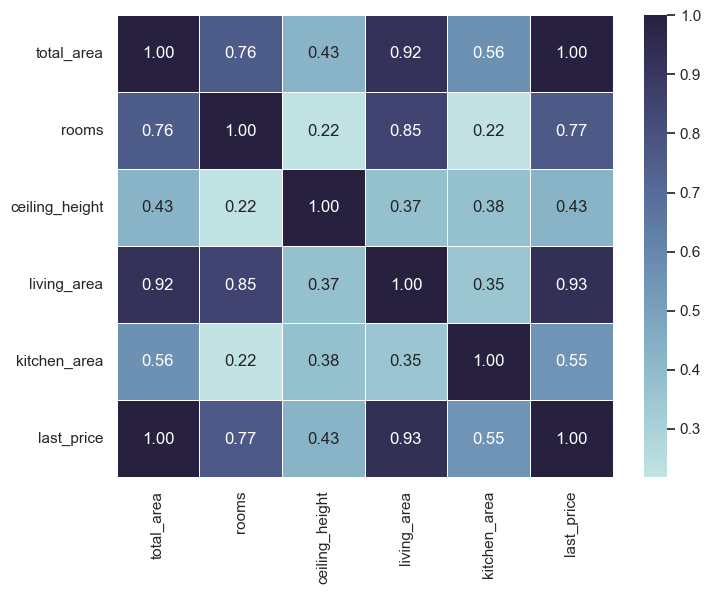

In [44]:
# построим график вида хитмэп
plt.figure(figsize=(8, 6))
sns.heatmap(
    features_corr.select_dtypes(include='number').corr(), annot=True, fmt=".2f", linewidths=.5,
    cmap=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True))
plt.show()

Всего таких признаков осталось 13 из 26. Как оказалось, оставшиеся 13 признаков не имели корреляции с целевой переменной в принципе либо имели, но очень слабую. Однако подобный отбор может привести к потере информации, если важные признаки окажутся неучтёнными. Именно так и оказалось на этапе обучения моделей, ведь 13 признаков, не попавших в итоговый датасет, вносили большой вклад в итоговый результат, поэтому от выбора только высококоррелированных признаков для линейных моделей необходимо отказаться. Ансамбли же наоборот не любят большое количество признаков. Чем больше признаков, тем больше корреляция между деревьями и тем меньше чувствуется эффект от ансамблирования.

## 7. Машинное обучение (ML)
---

### 7.1. Постановка задачи обучения
---
Мы хотим моделировать зависимость $y_i$ от $x_i$ как линейную функцию со свободным членом. Общий вид такой функции выглядит следующим образом:

$$\color{#348FEA}{f_w(x_i) = \langle w, x_i \rangle + w_0}$$

Для этого необходимо, чтобы на обучающем датасете  (то есть на парах $(x_i, y_i)$ из обучающей выборки) функция $f_w$ как можно лучше приближала зависимость. Для этого используются различные функции потерь — от их выбора зависит то, насколько задачу в дальнейшем легко решать, и то, в каком смысле получится приблизить предсказание модели к целевым значениям. Поскольку векторы находятся в одном пространстве, то расстояние между ними может являться функцией потерь. Для текущей задачи возьмем в качетсве функции потерь — Евклидово расстояние:

$$\color{#348FEA}{L(f, X, y) = |y - f(X)|_2^2 = \|y - Xw\|_2^2 = \sum_{i=1}^N(y_i - \langle x_i, w \rangle)^2}$$

В качестве метрики качества будет использоваться среднеквадратичное отклониение (Mean Squared Error, MSE), поскольку является более интерпретируемой, нежели $L^2$-норма:

$$\color{#348FEA}{\text{MSE}(f, X, y) =  \frac{1}{N}|y - X w|_2^2}$$

Для каждой конкретной линейной функции, которую задают веса $w_i$, мы получаем число, которое оценивает, насколько точно эта функция приближает наши значения $y$. Чем меньше это число, тем точнее наше решение, значит для того, чтобы найти лучшую модель, этот функционал нам надо минимизировать по $w$:

$$\color{#348FEA}{{|y - Xw|_2^2 \longrightarrow \min_w}}$$

In [45]:
# OneHotEncoding
features = pd.get_dummies(features, columns=cat_col_names, drop_first=True)

target = features['last_price']
features = features.drop('last_price', axis=1)

# сохраним названия столбцов
features_col_names = features.columns

# нормализуем данные
scaler = MinMaxScaler(feature_range=(0, 1))
features = scaler.fit_transform(features)

# делим на выборки
features_train, features_test, target_train, target_test = train_test_split(
    features, target, train_size=0.8, random_state=22, shuffle=True)

### 7.2.1. Линейная регрессия (точный аналитический метод)
---
Эту задачу можно решать разными способами. Для начала используем геометрические метод. Задачу регрессии можно сформулировать следующим образом: необходимо найти линейную комбинацию столбцов $x^{(1)},\ldots,x^{(D)}$, которая наилучшим способом приближает столбец $y$ по Евклидовой норме – то есть найти проекцию вектора $y$ на подпространство, образованное векторами $x^{(1)},\ldots,x^{(D)}$. Для этого нам нужно найти вектор весов, чтобы расчитать важность признака. Зная, что в итоге проекция должна быть равна целевой переменно $Xw = y$, можно вывести формулу. Вначале надо домножить обе части уравнения на $X^{-1}$:

$$\color{#348FEA}{X^{-1}Xw=X^{-1}y}$$

Зная, что $XX^{-1} = E$ — единичная матрица ($Ew = w$), получаем:

$$\color{#348FEA}{w = X^{-1}y}$$

С точки зрения математики мы получили верное уравнение, но на практике не найдется решения, если $X$ не является квадратной матрицей (mxm), что стремится к нулю. Но домножив уравнение на обратную матрицу, мы получим необходимую квадратную матрицу:

$$\color{#348FEA}{X^TXw=X^Ty}$$

Теперь при $w$ стоит множитель, от которого нужно избавиться. Для этого надо умножить обе части уравнения на этот множитель, но обратный:

$$\color{#348FEA}{(X^TX)^{-1}(X^TX)w=(X^TX)^{-1}X^Ty}$$

Матрица умноженная на обратную матрицу исчезает и остается вектор весов, который мы и искали:

$$\color{#348FEA}{w=(X^TX)^{-1}X^Ty}$$

Но всегда ли решение задачи регрессии единственно? На самом деле нет, если в выборке два признака будут линейно зависимы и ранг матрицы будет меньше $D$, о гарантировано найдётся такой вектор весов $\nu$, что $\langle\nu, x_i\rangle = 0\ \ \forall x_i$. В итоге, если какой-то $w$ является решением оптимизационной задачи, то и $w + \alpha \nu$ тоже является решением для любого $\alpha$. Конечно, в жизни редко бывает так, что признаки строго линейно зависимы, а вот быть приближённо линейно зависимыми они вполне могут быть. Для того, чтобы справиться с этой проблемой, задачу необходимо регуляризировать, то есть добавить к ней дополнительное ограничение на вектор весов. Это ограничение можно, как и исходный лосс, задавать по-разному, но, как правило, ничего сложнее, чем $L^1$ и $L^2$-нормы, не требуется. Вместо исходной задачи теперь предлагается решить такую:

$$\color{#348FEA}{\min_w L(f, X, y) = \min_w(|X w - y|_2^2 + \lambda |w|^k_k )}$$

Используем $L^2$-регуляризацию для решения нашей задачи, продифференцировав по $w$, тогда получится, что точное решение имеет вид:

$$\color{#348FEA}{w = (X^TX + \lambda I)^{-1}X^Ty}$$

По логике, раз матрица $X^TX$ близка к вырожденной, то обращать её нельзя, поэтому лучше слегка исказить её, добавив $\lambda I$ и отодвинуть все значения от нуля. Да, аналитическое решение перестаёт быть точным, но за счёт снижения численных проблем получается более качественное решение, чем при использовании точной формулы.

In [46]:
# модель линейной регрессии
class LinearRegression:
    
    # функция обучения
    def fit(self, x, y):
        # добавляем смещение в вектор признаков
        x = np.concatenate((np.ones((x.shape[0], 1)), x), axis=1)
        # находим веса по ранее выведенной формуле
        w = np.dot(np.dot(np.linalg.inv(np.dot(x.T, x)), x.T), y)
        
        # сохраняем веса и смещение
        self.coef_ = self.w = w[1:]
        self.intercept_ = self.w0 = w[0]
    
    # функция предсказания
    def predict(self, x):
        return np.dot(x, self.w) + self.w0


model = LinearRegression()
model.fit(features_train, target_train)

Модель обучена, осталось проверить точность ответов, используя метрику MAE, чтобы понять, как далеко отклонилась оценка модели от истинных значений.

$$MAE = \frac{1}{n} \sum^n_{i=1}|y_i - \hat{y}_i|$$

In [47]:
mean_absolute_error(model.predict(features_test), target_test)

22021.126397996297

Результат неплохой, особенно для самой простой модели. Попробуем понять, какой признак вносил наибольший вклад в ответы модели, оценив коэффициенты.

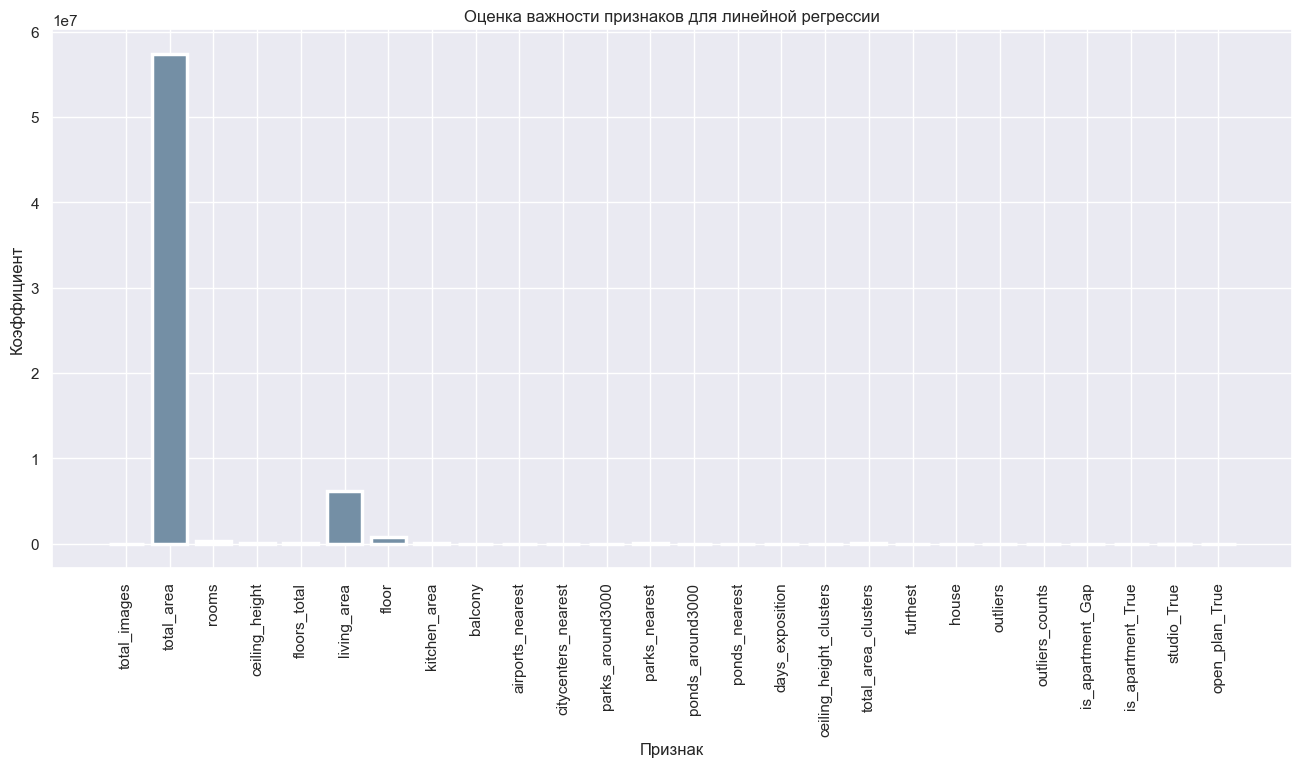

In [48]:
plt.bar(features_col_names, model.coef_, lw=2.5, color="#748fa5")
plt.title('Оценка важности признаков для линейной регрессии')
plt.ylabel('Коэффициент')
plt.xlabel('Признак')
plt.xticks(rotation = 90);

Самым важным для модели линейной регрессии оказался признак «total_area», описывающий общую площадь продаваемого жилого помещения. За ним следует признак «living_area», описывающий площадь жилых помещений. Тройку лидеров закрывает признак «floor», описывающий этаж жилого помещения.

### 7.2.2. Линейная регрессия (численный метод)
---
Прямые методы помогают найти точное решение по заданной формуле или алгоритму, но их вычислительная сложность не зависит от данных. Даже если в выборке все ответы и искомые веса равны нулю — алгоритм всё равно проделает все матричные умножения для поиска решения. Вычислительная сложность подобного алгоритма $O(N^2D + D^3)$, а значит чем больше признаков в выборке, тем дольше будет происходить обучение. На помощь в такой ситуации приходят численные методы. Они не дают точного решение, только приближенное, зато многократно ускоряют вычисления. Вычислительная сложность градиентного спуска $O(NDS)$.

Как известно, градиент функции в точке направлен в сторону её наискорейшего роста, а антиградиент (противоположный градиенту вектор) в сторону наискорейшего убывания. То есть имея какое-то приближение оптимального значения параметра $w$, мы можем его улучшить, посчитав градиент функции потерь в точке и немного сдвинув вектор весов в направлении антиградиента:

$$\color{#348FEA}{w_j \mapsto w_j - \alpha \frac{d}{d{w_j}} L(f_w, X, y)}$$

Найдем градиент, взяв производную от квадрата евклидовой нормы:

$$\color{#348FEA}{\nabla_wL = \frac2{N} X^T (Xw - y)}$$

Градиент означает, что начав свой путь из начального приближения, мы можем итеративно уменьшать значение функции, пока не сойдемся к минимуму. Основная проблема градиентного спуска в том, что на каждом шаге требуется выполнить потенциально дорогую операцию вычисления градиента по всей выборке. Для решения данной проблемы можно заменить градиент его оценкой на подвыборке (батче):


$$\color{#348FEA}{\nabla_wL(w, X, y) \approx \frac1B\sum_{t=1}^B\nabla_wL(w, x_{i_t}, y_{i_t})}$$

Сложность по времени не изменилась $O(NDE)$, но мы сделали в $N / B$ раз больше шагов, из-за чего веса модели претерпели намного больше обновлений. В целом, разницу между алгоритмами можно представлять как-то так:

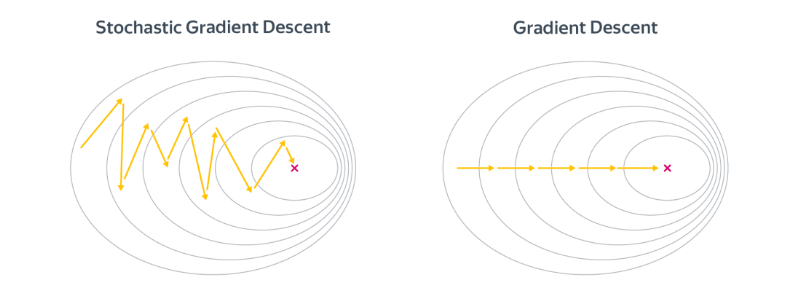

Иллюстрация взята с сайта: [ссылка](https://clck.ru/37iJtb)

Добавим в формулу $L^2$-регуляризацию, чтобы отодвинуть значения от нуля и избежать линейной зависимости. В итоге формула приобретает вид:

$$\color{#348FEA}{\nabla_wL(f_w, X, y) = 2X^T(Xw - y) + 2\lambda w}$$

Подставив этот градиент в алгоритм стохастического градиентного спуска, мы получаем обновлённую версию приближенного алгоритма, отличающуюся от старой только наличием дополнительного слагаемого.

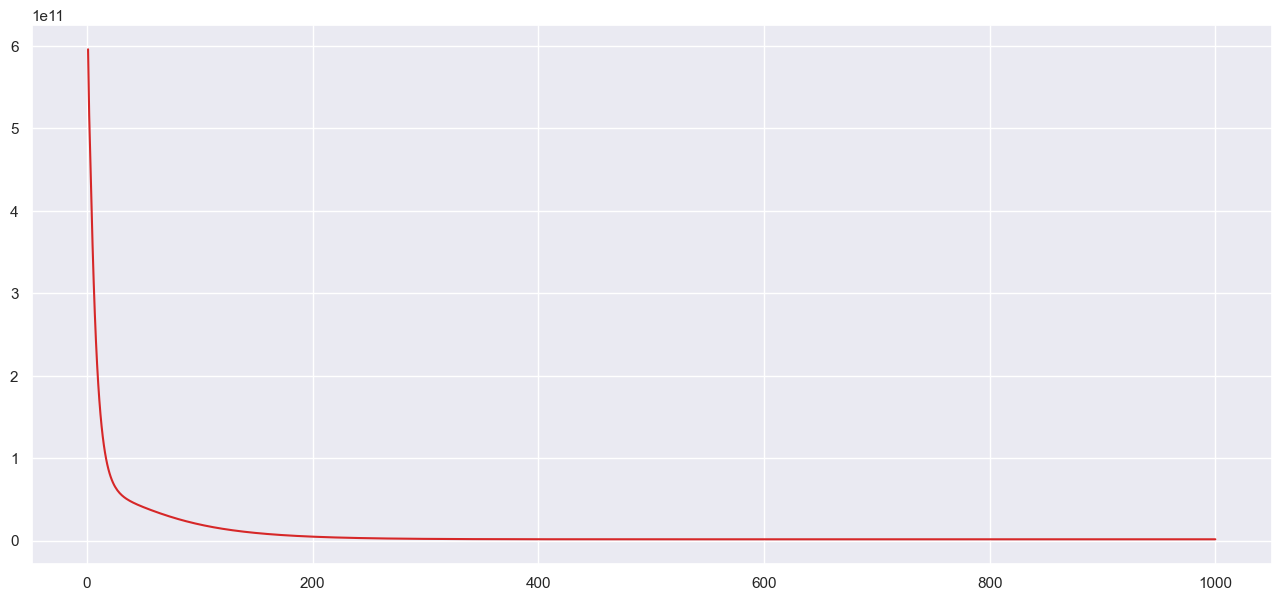

In [49]:
# модель линейной регрессии
class LinearRegression:
    
    # функция инициализации
    def __init__(self, epochs, batch_size, regularization_rate=0, learning_rate=0.01):
        self.regularization_rate = regularization_rate
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
    
    # функция обучения
    def fit(self, x, y):
        # добавляем смещение в вектор признаков
        x = np.concatenate((np.ones((x.shape[0], 1)), x), axis=1)
        w = np.random.normal(0, 1, x.shape[1])
        
        # список для метрики
        mse = []
        
        # итерируем по количеству эпох
        for e in range(self.epochs):
            
            # итерируем по количеству батчей
            for b in range(x.shape[0] // self.batch_size):
                
                # берем необходимые выборки
                x_batch = x[b * self.batch_size:(b + 1) * self.batch_size, :]
                y_batch = y[b * self.batch_size:(b + 1) * self.batch_size]
                
                # считаем предварительный градиент
                gradient = 2 * x_batch.T.dot(x_batch.dot(w) - y_batch) / x_batch.shape[0]
                
                # считаем итоговый градиент
                gradient += self.regularization_rate
                
                # обновляем веса
                w -= self.learning_rate * gradient
            
            # вычисляем MSE на каждой эпохе
            mse.append(sum((x_batch.dot(w) - y_batch) ** 2) / len(y_batch))
        
        # сохраняем веса и смещение
        self.coef_ = self.w = w[1:]
        self.intercept_ = self.w0 = w[0]
        
        # строим график обучения
        plt.plot(range(1, self.epochs + 1), mse, color='tab:red')
    
    # функция предсказания
    def predict(self, x):
        return np.dot(x, self.w) + self.w0


model = LinearRegression(epochs=1000, batch_size=100, regularization_rate=0.01, learning_rate=0.2)
model.fit(features_train, target_train)

In [50]:
mean_absolute_error(model.predict(features_test), target_test)

21733.58198220292

Удалось добиться снижения ошибки, используя градиентный спуск. Посмотрим, изменились ли значимые признаки.

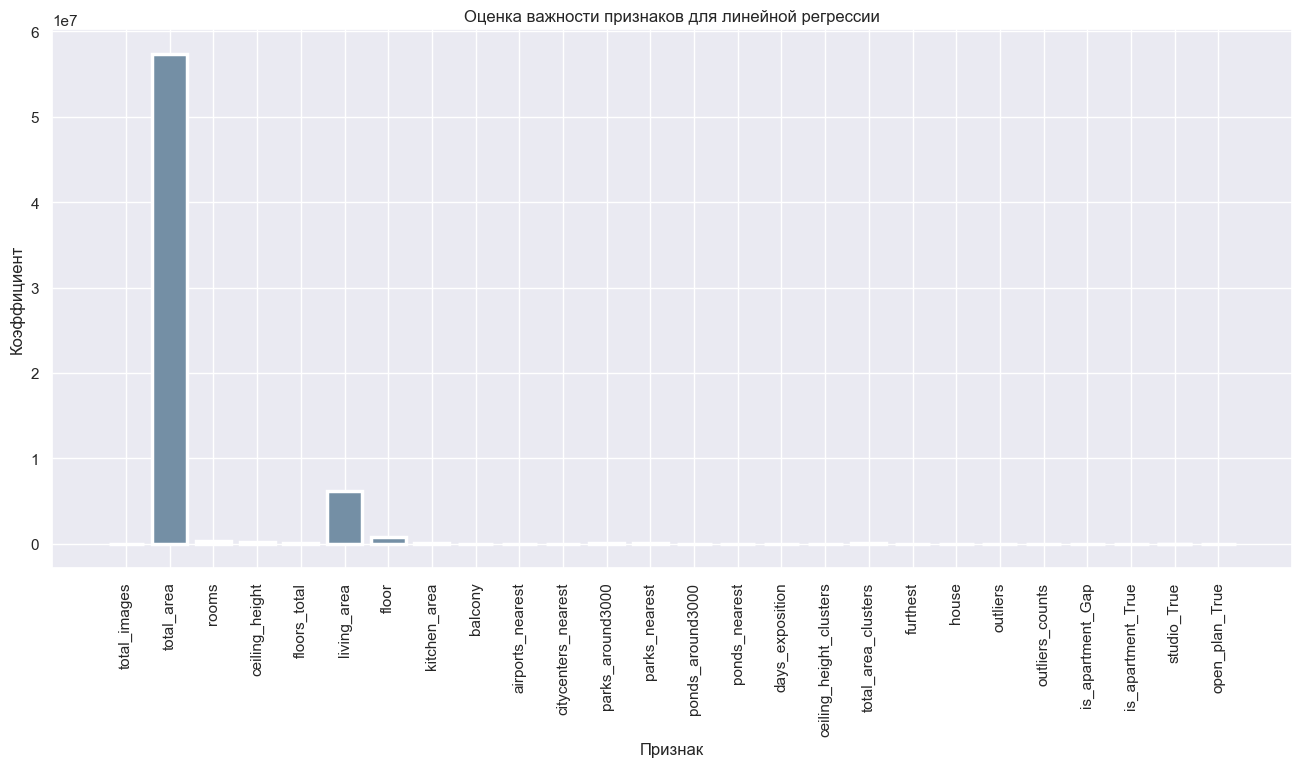

In [51]:
plt.bar(features_col_names, model.coef_, lw=2.5, color="#748fa5")
plt.title('Оценка важности признаков для линейной регрессии')
plt.ylabel('Коэффициент')
plt.xlabel('Признак')
plt.xticks(rotation = 90);

Значимые признаки остались без изменений, мог поменяться немного только сам коэффициент.

### 7.3. Cлучайный лес
---
Опустим деревья решений и перейдём сразу же к случайному лесу, поскольку он обладает одним прекрасным алгоритмом, называемым бутстрепом. Преимущества случайного леса в том, что если предположить, что базовые алгоритмы некоррелированы, то:

$$\color{#348FEA}{\mathbb{V}_X[a(x, X)] = \frac{1}{k^2} \sum_{i = 1}^k \mathbb{V}_X b(x, X^i) = \frac{1}{k^2} \sum_{i = 1}^k \mathbb{V}_X b(x, X) = \frac{1}{k} \mathbb{V}_X b(x, X)}$$

Это означает, что в этом случае дисперсия композиции в $k$ раз меньше дисперсии отдельного алгоритма.

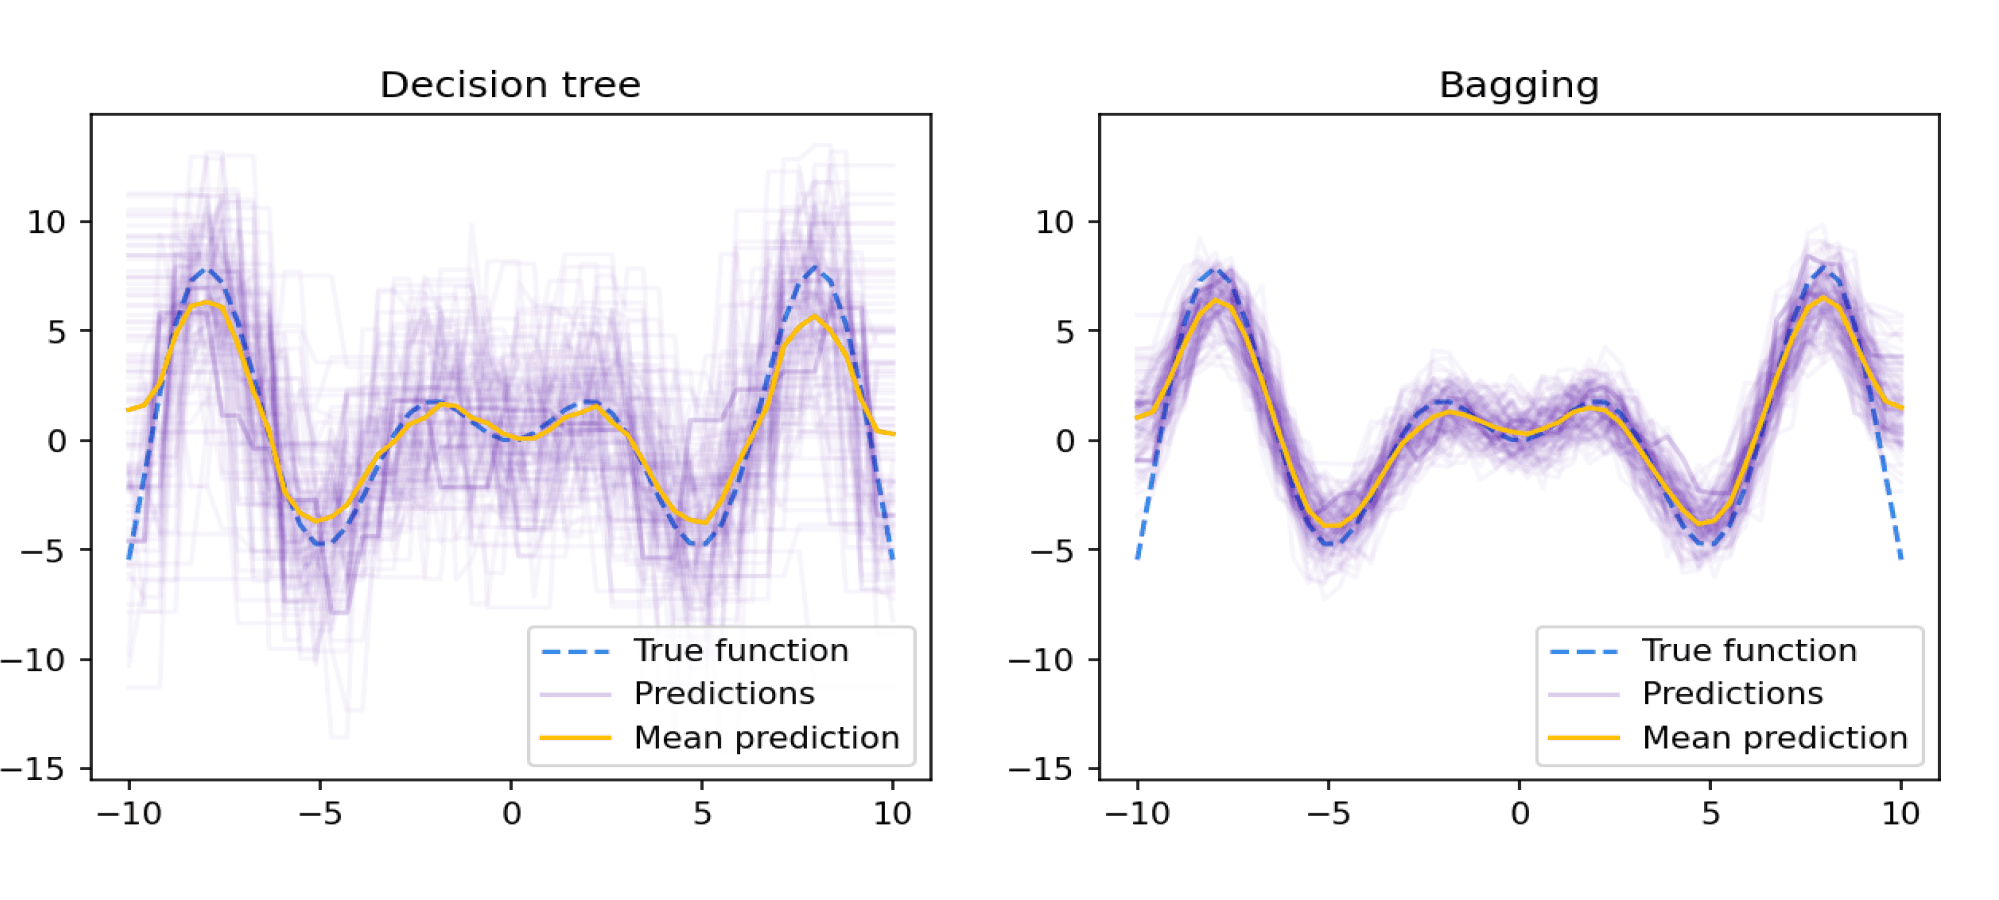

По этому рисунку видно, что общая дисперсия предсказаний в зависимости от обучающего множества у бэггинга значительно ниже, чем у отдельных деревьев, а в среднем предсказания деревьев и бэггинга не отличаются.

<b> О глубине деревьев:</b> Модель может допускать ошибки, и мы можем на них повлиять. Эти ошибки можно разделить на два вида: смещение и разброс. Разброс мы можем уменьшить с помощью процедуры бэггинга, но на смещение это не повлияет. А нам бы хотелось, чтобы у ансамбля было небольшое смещение. Поэтому и сами деревья, из которых строится ансамбль, должны иметь небольшое смещение. У неглубоких деревьев мало параметров, то есть они могут запомнить только общие закономерности обучающей подвыборки. Эти закономерности будут схожи во всех подвыборках, но не будут детально описывать целевую зависимость. Из-за этого предсказание на тестовом объекте будет стабильным, но не точным (низкая дисперсия, высокое смещение). С другой стороны, у глубоких деревьев нет проблем с детальным запоминанием подвыборки. Поэтому предсказание на тестовом объекте будет больше зависеть от обучающей подвыборки, но в среднем будет ближе к истине (высокая дисперсия, низкое смещение).

<b>О количестве признаков:</b> Управляя количеством признаков, которые используются при обучении одного дерева, мы также контролируем качество случайного леса. Чем больше признаков, тем сильнее корреляция между деревьями и тем менее заметным становится эффект от объединения. С другой стороны, чем меньше признаков, тем слабее результаты работы отдельных деревьев. Для задачи регрессии рекомендуют брать треть всех признаков.

Для деревьев решение было принято использовать поиск гиперпараметров по сетке, чтобы учесть все возможные комбинации и получить достойный результат. Поскольку вычисление проходит долго, данная ячейка будет закомментирована, чтобы не вызвать её повторно.

In [52]:
# model = RandomForestRegressor(random_state=22, n_jobs=-1)

# params = {
#     'criterion': ['squared_error', 'absolute_error'],
#     'n_estimators': [100, 200, 300, 400, 800],
#     'max_depth': [10, 15, 20, 25]
# }

# grid_search = GridSearchCV(model, params, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1, verbose=True)

# grid_search.fit(features_train, target_train)

# print(f'Лучший результат: {grid_search.best_score_}')
# print(f'Лучшие параметры: {grid_search.best_params_}')

Оптимальные для задачи гиперпараметры, это ошибка «squared_error» и 400 деревьев с глубиной 20. Обучим модель и оценим результаты.

In [53]:
# модель случайного леса
model = RandomForestRegressor(random_state=22, criterion='squared_error', n_estimators=400, max_depth=20, n_jobs=-1)

model.fit(features_train, target_train)
predictions = model.predict(features_test)

mean_absolute_error(predictions, target_test)

47038.78338409815

По результатам видно, что линейная связь у признаков после обработки намного более выраженная, чем иные связи, с которыми деревья решений должны были справиться лучше. По итогу на данный момент лидирует именно линейная регрессия.

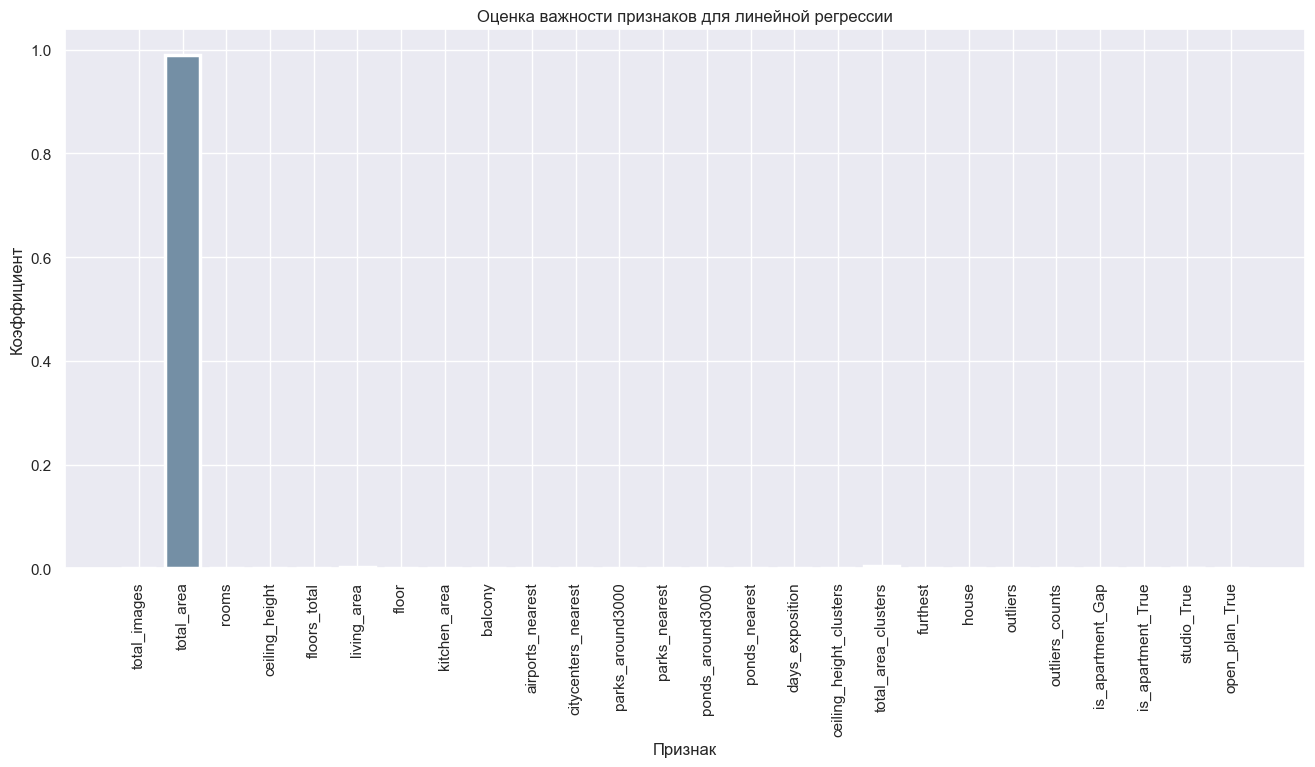

In [54]:
plt.bar(features_col_names, model.feature_importances_, lw=2.5, color="#748fa5")
plt.title('Оценка важности признаков для линейной регрессии')
plt.ylabel('Коэффициент')
plt.xlabel('Признак')
plt.xticks(rotation = 90);

В случайном лесу наиболее важным признаком является «total_area». На втором месте оказался признак «total_area_cluster», который описывает разделение жилой площади на кластеры. Было ожидаемо, что для деревьев решений он будет значим, но предполагалось, что значимость будет выше.

### 7.4. Нейронные сети
---
Вот мы и добрались до нейронной сети, позволяющей оценить не только линейные, но и нелинейные зависимости за счёт различных функций активации. Но как это происходит? Всё просто. Когда на вход нейрона поступают признаки $x$, они умножаются на матрицу весов $w$, суммируются и добавляют смещение. В первый раз веса и сдвиг в матрице выбираются абсолютно случайными, а на следующих шагах благодаря алгоритму обратного распространения ошибки (back propagation).

$$\color{#348FEA}{x = b + \sum^n_{i=1}\omega_{ji}x_i}$$

Далее в игру вступает функция активации, которая сравнивает сумму с пороговыми значениями и присваивает ему одно из них. Бывают разные функции активации, например, логистическая, распределённая от 0 до 1 и часто используемая в бинарной классификации:

$$\color{#348FEA}{f(x)= \frac{1}{1 + e^{−x}}}$$

Также существует гиперболический тангенс, который обычно используется в скрытых слоях нейронной сети, так как его значения распределены от -1 до 1. Это помогает центрировать данные и значительно облегчает обучение для следующего слоя:

$$\color{#348FEA}{f(x)= \frac{e^x-e^{-x}}{e^x+e^{-x}}}$$

Линейная же функция часто встречается в конце нейронной сети, если решается задача регрессии, поскольку график функции представляет собой прямую линию. 

$$\color{#348FEA}{Linear(x)=k⋅x}$$

Но мы будем использовать функцию активации ReLU, поскольку она очень проста в вычислении, что делает ее эффективной для использования в больших моделях.Также ReLU решает проблему затухающего градиента, поскольку его производная равна единице для положительных значений, что позволяет градиентам оставаться большими и предотвращать их исчезновение. Именно это свойство повышает скорость сходимости, ведь градиент не исчезает.

$$\color{#348FEA}{ReLU(x)=max(0,x)}$$

А что же там с оптимизаторами? У них тоже существует множество разновидностей, от обычного стохастического градиентного спуска (SGD), который вычисляет частные производные по батчам, и улучшенной его версии с моментами Нестерова, смысл которых заключается в придании инерции к вычисляемым градиентам, что позволит избежать застревание в неглубоких ямах, до оптимизатора Adagrad, который учитывает параметры, приближенные к своему оптимуму, и меняет их с меньшим шагом, что сильно ускоряет сходимость при сильно разряженных данных, и его улучшенной версии оптимизатора Adam, который использует сглаженные версии среднего и среднеквадратического градиента.

$$\color{#348FEA}{m_t = \beta_1m+(1-\beta_1)\cdot g_t \\ v_t=\beta_2+(1-\beta_2)\cdot g_t^2 \\ u_t=-\frac{\eta}{\sqrt{v+e}}\cdot m_t}$$

Теперь выберем критерий качества для задачи регрессии. Мы могли бы взять средний квадрат ошибок MSE, но его главный недостаток — множество локальных минимумов. Кроме того, критерий резко возрастает, когда появляются значимые ошибки.

$$\color{#348FEA}{E = \frac{1}{N} \sum^N_{i=1} (d_i - y_i)^2}$$

Тогда мы могли бы взять его противоположность, а именно средний квадрат логарифмических ошибок MSLE. В отличие от обычной суммы квадратов, использование логарифмических ошибок значительно уменьшает редкие, но большие ошибки, из-за чего критерий качества растет медленно. 

$$\color{#348FEA}{E = \frac{1}{N} \sum^N_{i=1} (\log(d_i+1)-\log(y_i+1))^2}$$

На помощь приходит средний модуль ошибок MAE. Данный способ лучше, так как ошибка не возводится в квадрат, из-за чего большие ошибки не так быстро начинают увеличивать показатель ошибки.

$$\color{#348FEA}{E = \frac{1}{N} \sum^N_{i=1} |d_i - y_i|}$$

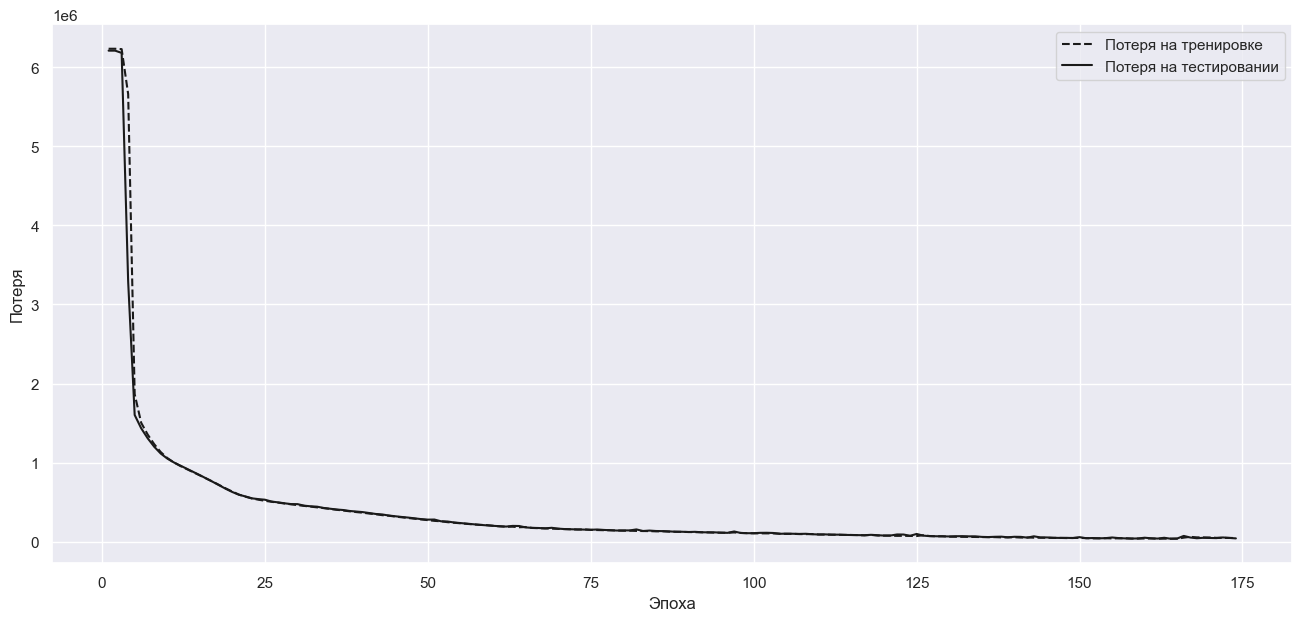

In [55]:
# модель нейронной сети
model = Sequential()

# добавляем 4 полносвязных слоя с функцией активации ReLU
model.add(Dense(units=512, activation='ReLU', input_shape=(features_train.shape[1],)))
model.add(Dense(units=512, activation='ReLU'))
model.add(Dense(units=512, activation='ReLU'))
model.add(Dense(units=512, activation='ReLU'))

# добавляем 2 полносвязных слоя с функцией активации ReLU и регуляризацией L2
model.add(Dense(units=256, activation='ReLU', kernel_regularizer=regularizers.L2(0.001)))
model.add(Dense(units=256, activation='ReLU', kernel_regularizer=regularizers.L2(0.001)))

# добавляем 4 полносвязных слоя с функцией активации ReLU
model.add(Dense(units=128, activation='ReLU'))
model.add(Dense(units=128, activation='ReLU'))
model.add(Dense(units=128, activation='ReLU'))
model.add(Dense(units=128, activation='ReLU'))

# добавляем 2 полносвязных слоя с функцией активации ReLU и регуляризацией L2
model.add(Dense(units=64, activation='ReLU', kernel_regularizer=regularizers.L2(0.001)))
model.add(Dense(units=64, activation='ReLU', kernel_regularizer=regularizers.L2(0.001)))

# добавляем 4 полносвязных слоя с функцией активации ReLU
model.add(Dense(units=32, activation='ReLU'))
model.add(Dense(units=32, activation='ReLU'))
model.add(Dense(units=32, activation='ReLU'))
model.add(Dense(units=32, activation='ReLU'))

# добавляем 2 полносвязных слоя с функцией активации ReLU и регуляризацией L2
model.add(Dense(units=16, activation='ReLU', kernel_regularizer=regularizers.L2(0.001)))
model.add(Dense(units=16, activation='ReLU', kernel_regularizer=regularizers.L2(0.001)))

# добавляем выходной слой с линейной функцией
model.add(Dense(units=1))

# компилируем нейронную сеть с оптимизатором Adam и функцией потерь MSE
model.compile(loss='mae', optimizer=Adam(learning_rate=0.0001), metrics=['mae'])

# создаём коллбек
callbacks = [
    # если модель не улучшает функцию потерь больше 10 эпох, останавливаем её
    EarlyStopping(monitor='val_loss', patience=10),
    # сохраняем модель, которая была 10 эпох назад
    ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)
]

# обучаем нейронную сеть
history = model.fit(
    features_train, target_train, batch_size=500, epochs=1000, verbose=0,
    validation_data=(features_test, target_test), callbacks=callbacks
)

# Получаем историю потерь
training_loss = history.history['mae']
test_loss = history.history['val_mae']
epoch_count = range(1, len(training_loss) + 1)

# Визуализация истории потерь
plt.plot(epoch_count, training_loss, 'k--')
plt.plot(epoch_count, test_loss, 'k-')
plt.legend(['Потеря на тренировке', 'Потеря на тестировании'])
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.show();

Функция потерь перестала уменьшаться на протяжении 10 эпох, из-за чего обучение модели было остановлено. Насколько видно из графика, расхождение по тренировочной и тестовой выборке минимально, а значит, регуляризация помогла избежать сильного расхождения. Интересно заметить, что MAE дала лучшие результаты, чем MSE. Скорее всего, это произошло из-за того, что модель с MSE попала в локальный минимум, из которого не смогла выбраться за 10 эпох. Перейдём к оценке результатов, чтобы понять, насколько хорошо справилась модель.

In [56]:
mean_absolute_error(model.predict(features_test), target_test)

146/146 [==============================] - 0s 2ms/step


43173.21619226638

Итоговая оценка ниже, чем у случайного леса, но выше, чем у линейной модели. Это может говорить о необходимости изменить структуру слоёв либо изменить количество нейронов и функций активации.

## 8. Выводы
---

Была произведена большая работа по анализу данных, где мы поняли, что данные не распределены по нормальному закону, а сильно смещены в правую сторону. Были сделаны предположения о пропусках в данных и найдены предполагаемые значения, которые могут быть на их месте. А также были найдены выбросы, которые прятались в данных, которых оказалось больше, чем предполагалось. Обработка же выбросов заставила использовать более защищённый метод, на основе правила трёх сигм.

Была произведена обработка данных на основе произведённого анализа, а также добавлены новые признаки, в том числе и на основе кластеризации данных.

Были найдены все признаки, имеющие корреляцию с целевой переменной свыше 0,25, но в процессе исследования сделан вывод о необходимости отказаться от этой идеи, поскольку линейная модель, дающая лучший результат, учитывала все признаки, даже имеющие незначительную корреляцию.

Самыми важными признаками оказались признаки: «total_area», описывающий общую площадь продаваемого жилого помещения. За ним следует признак «living_area», описывающий площадь жилых помещений. А в конце признак «floor», описывающий этаж жилого помещения.

Поскольку в задачах описывалась важность интерпритируемости результатов, то предпочтение было отдано метрике MAE, позволяющей оценить результаты без возведения в квадрат.

В конце были обучены три модели, из которых наилучший результат показала линейная регрессия, основанная на численных методах, использующих градиентный спуск.с ошибкой MAE 21733.58, что относительно цен на квартиры является допустимой ошибкой, позволяющей с точностью определить, сколько стоит объект недвижимости.